# ESTIMATION OF THE PARAMETER H

In [2]:
# Import necessary libraries
import numpy as np
import math
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
# Parameters for the Lifted Heston model
n, V0, lam, theta, nu, alpha, r = 20, 0.05, 0.3, 0.05, 0.1, 0.6, 8

## Question 1

Let $V_t$ be the spot variance of a Lifted Heston model with $n$ factors and initial curve $g_0(t)$ given by

$$
g_0(t) = V_0 + \lambda \theta \sum_{i=1}^{n} c_i \int_0^t e^{-x_i s} ds.
$$

Let us recall that the variance process in the Lifted Heston model is the following:

$$
V_t = g_0(t) + \sum_{i=1}^{n} c_i U_t^i
$$

where each factor $U_t^i$ satisfies the stochastic differential equation

$$
dU_t^i = (-x_i U_t^i - \lambda V_t) \, dt + \nu \sqrt{V_t} \, dW_t
$$

with $d\langle B, W \rangle_t = \rho \, dt$.

The weights $(c_i)_{i=1}^n$ and the mean reversions $(x_i)_{i=1}^n$ are as follows, with a constant $r$ denoted $r_n$, and defined as:

- **Weights**:
  $$
  c_i = \frac{r^{1 - \alpha} - 1}{\Gamma(\alpha)\Gamma(2 - \alpha)} \cdot r^{(1 - \alpha)\left(i - 1 - \frac{n}{2}\right)}
  $$

- **Mean reversions**:
  $$
  x_i = \frac{(1 - \alpha)(r^{2 - \alpha} - 1)}{(2 - \alpha)(r^{1 - \alpha} - 1)} \cdot r^{i - 1 - \frac{n}{2}}
  $$

Consider a Lifted Heston model with $n = 20$ factors and the following parameters:

- $V_0 = 0.05$
- $\lambda = 0.3$
- $\theta = 0.05$
- $\nu = 0.1$
- $\alpha = H + 0.5 = 0.6$
- $r_{20} = 8$

In [9]:
# Computation of c and x following the formula above
c = np.array([(r**(1 - alpha) - 1) * (r**((1 - alpha) * (ii - 1 - n / 2))) / (math.gamma(alpha) * math.gamma(2 - alpha)) for ii in range(1, n + 1)])
x = np.array([(1 - alpha) * (r**(2 - alpha) - 1) * (r**(ii - 1 - n / 2)) / ((2 - alpha) * (r**(1 - alpha) - 1)) for ii in range(1, n + 1)])

In [10]:
# Function to compute g(t) for any value of t using the formula above
def g0(t):
    integral = (1 - np.exp(-x * t)) / x # explicit formula for the integral contained in the second term of of g0(t)
    return V0 + lam * theta * c @ integral

In [11]:
# Parameters for the simulation
t0, tm, m, delta_t = 0, 1, 10**5, 1e-5
time_grid = np.linspace(t0, tm, m + 1)

In [12]:
# Initilize vectors for the simulation
# dim(V) = m + 1 -> one value for each point in the time grid
# dim(U) = n -> one value for each factor (don't need to remember it through time so it is just a vector, not a matrix)
V, U = np.zeros(m + 1), np.zeros(n)

To simulate the variance process in the Lifted Heston model, we use an **implicit-explicit Euler scheme**. For a simulation $(W_{t_k})$ of a Brownian Motion on a uniform partition $(t_k)$ of the time horizon $[0,T]$ with  $\Delta t = t_k - t_{k-1}$ let:

- **Variance approximation** at time step $t_k$:

$$
\widehat{V}_{t_k} = g_0(t_k) + \sum_{i=1}^{n} c_i \, \widehat{U}^i_{t_k}, \quad \widehat{U}^i_0 = 0
$$

- **Euler update for each factor** $i = 1, \dots, n$:

$$
\widehat{U}^i_{t_{k+1}} = \frac{1}{1 + x_i \Delta t} \left( \widehat{U}^i_{t_k} - \lambda \, \widehat{V}_{t_k} \Delta t + \nu \sqrt{ \max(0, \widehat{V}_{t_k}) } \, (W_{t_{k+1}} - W_{t_k}) \right)
$$

In [14]:
inc = npr.normal(0, np.sqrt(delta_t), m) # brownian increments used for the computation of U
V[0] = g0(0) # initial value of V since the first value of U (for each factor) is set to 0 in the scheme

for kk in range(1, m + 1):
    U = (1 / (1 + x * delta_t)) * (U - lam * V[kk - 1] * delta_t + nu * np.sqrt(max(0, V[kk - 1])) * inc[kk - 1]) # update U
    V[kk] = g0(time_grid[kk]) + c @ U # next value of V given the updated value of U

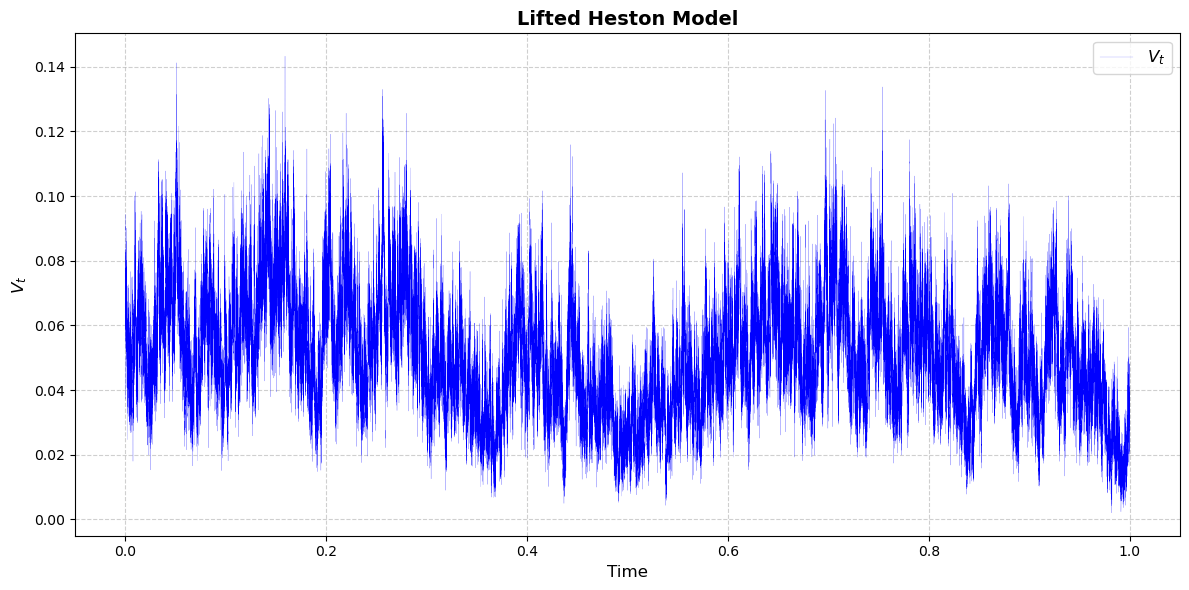

In [15]:
plt.figure(figsize=(12, 6))
plt.title("Lifted Heston Model", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel(r'$V_{t}$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.plot(time_grid, V, linewidth=0.1, color='b', label=r'$V_t$')
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

## Question 2

To estimate the regularity of the log-volatility process, we compute empirical moments of its increments. For a given moment order $q > 0$ and lag $\Delta$, the estimator is defined as:

$$
m(q, \Delta) = \frac{1}{M_\Delta} \sum_{i=1}^{M_\Delta} \left| \log(\sigma_{t_{i+\Delta}}) - \log(\sigma_{t_i}) \right|^q,
$$

where $M_\Delta$ is the number of increments of size $\Delta$ in the time series.

If the log-volatility process behaves similarly to a fractional Brownian motion with Hurst parameter $H$, we expect the following scaling law:

$$
m(q, \Delta) \propto \Delta^{qH}.
$$

In [18]:
def compute_zeta_q(V, q, lag_values):
    m_q_delta_values = []

    for delta in lag_values:
        # For a fixed value of q compute the empirical value of the moment of the increments of the volatility
        M_delta = len(V) - delta
        differences = np.log(V[delta:]) - np.log(V[:-delta])
        m_q_delta = (1 / M_delta) * np.sum(np.abs(differences)**q)
    
        m_q_delta_values.append(m_q_delta)

    # For a fixed value of q do a linear regression to compute the value of zeta_q
    lag_values, m_q_delta_values = np.array(lag_values), np.array(m_q_delta_values)
    slope, intercept, _ , _ , _ = linregress(np.log(lag_values), np.log(m_q_delta_values))

    return slope, intercept, np.log(lag_values), np.log(m_q_delta_values)

To estimate the Hurst parameter $H$, we perform a two-step regression procedure based on the scaling properties of the empirical moments.

- **First regression (scaling of moments):**

For each fixed moment order $q$, we compute $m(q, \Delta)$ over a range of lags $\Delta$ and fit a linear model in log–log scale:

$$
\log(m(q, \Delta)) \approx \zeta_q \log(\Delta) + C_q,
$$

where the slope $\zeta_q$ captures the scaling behavior of the $q$-th moment.

- **Second regression (linear relation with $q$):**

If the log-volatility process is close to a fractional Brownian motion, then the scaling exponent $\zeta_q$ is expected to grow linearly with $q$, and we fit:

$$
\zeta_q \approx H \cdot q + c,
$$

where the slope of this second regression gives an estimate of the Hurst parameter $H$.

In [20]:
def estimate_H(V, q_values, lag_values):
    zeta_q_values = []

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for q in q_values:
        # Compute the value of zeta_q for the given values of q
        zeta_q, C_q, lag, m_q_delta = compute_zeta_q(V, q, lag_values)
        zeta_q_values.append(zeta_q)

        axes[0].scatter(lag, m_q_delta, label=f'q={q}', s=10, marker='*')
        axes[0].plot(lag, zeta_q * lag + C_q, linestyle='-', label=' ')

    axes[0].set_title(r'Scaling of m(q,$\Delta$)', fontsize=14)
    axes[0].set_xlabel(r'Log($\Delta$)', fontsize=12)
    axes[0].set_ylabel(r'Log(m(q,$\Delta$))', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True)

    # Linear regression to estimate the value of H
    zeta_q_values, q_values = np.array(zeta_q_values), np.array(q_values)
    H_estimated, intercept, _ , _ , _ = linregress(q_values, zeta_q_values)

    axes[1].scatter(q_values, zeta_q_values, label=r'$\zeta_q$', color='blue', s=50)
    axes[1].plot(q_values, H_estimated * q_values + intercept, label='Linear fit', color='orange', linestyle='-')

    axes[1].set_title('Estimation of H', fontsize=14)
    axes[1].set_xlabel(r'$q$', fontsize=12)
    axes[1].set_ylabel(r'$\zeta_q$', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return H_estimated

In [21]:
# Parameters for estimation of H
q_values, lag_values = [0.5, 1, 1.5, 2], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

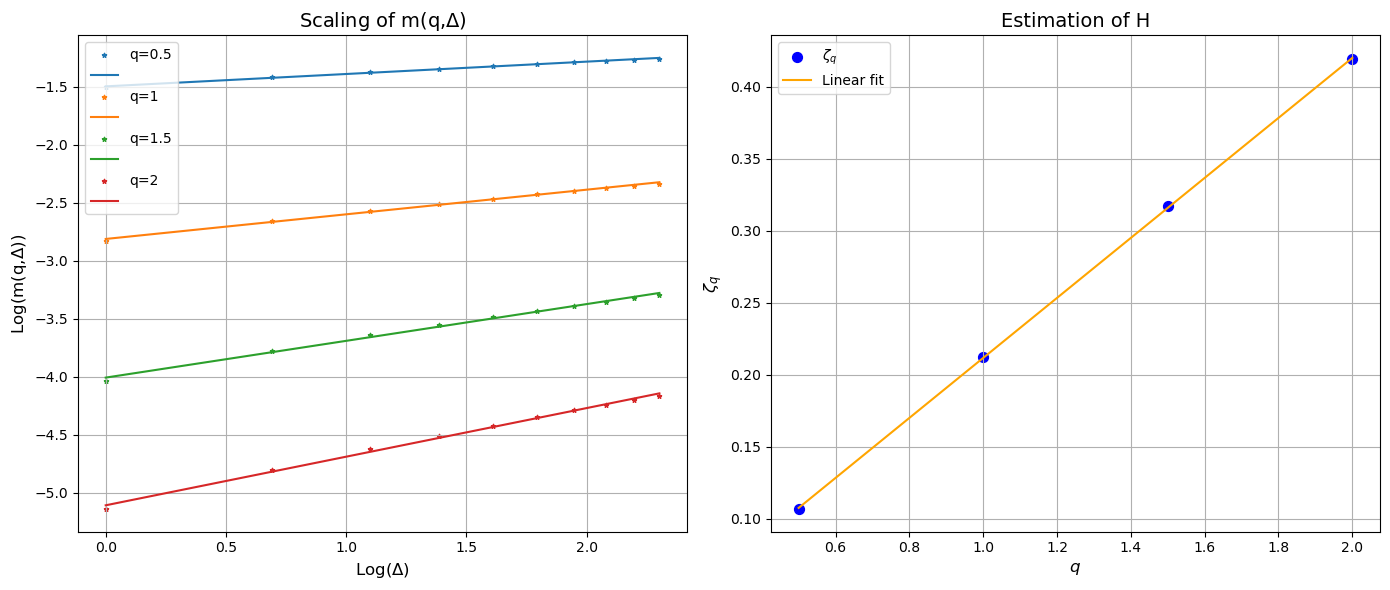

In [22]:
# Estimate H using the square root of the process simulated in the first question
H_estimated = estimate_H(np.sqrt(V), q_values, lag_values)

In [23]:
H_estimated

0.20846572437655597

## Question 3

In [25]:
# Parameters to compare l and H_estimated
l_values, H_estimated = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], []

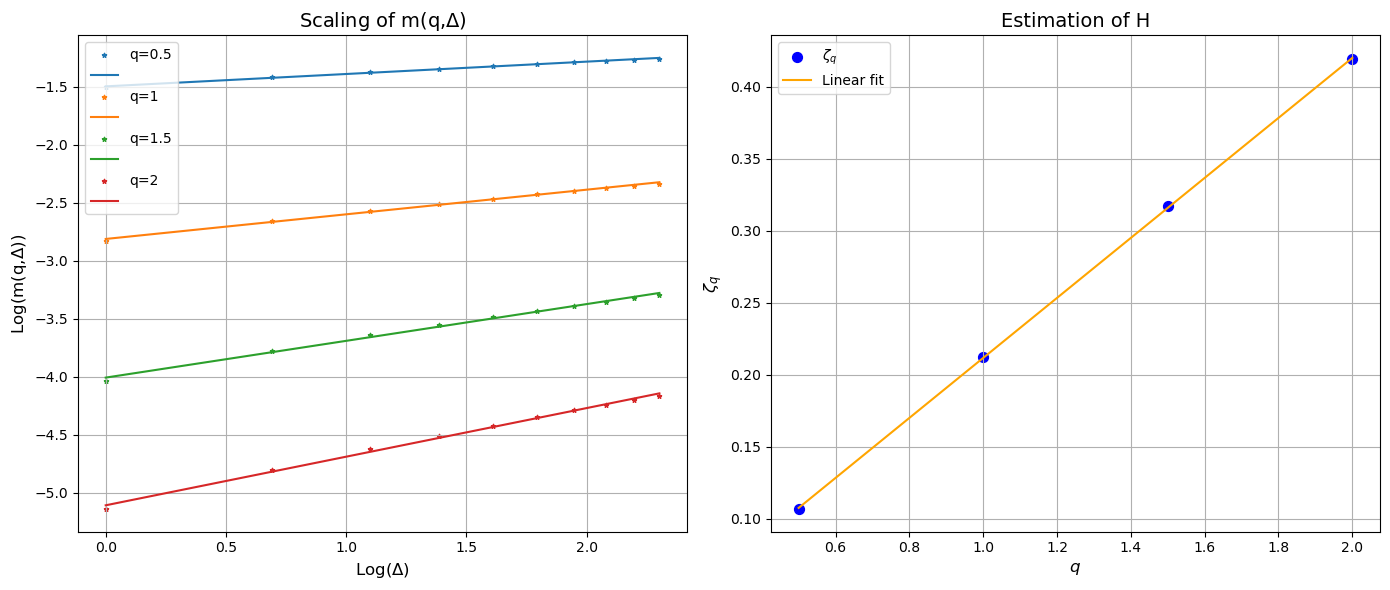

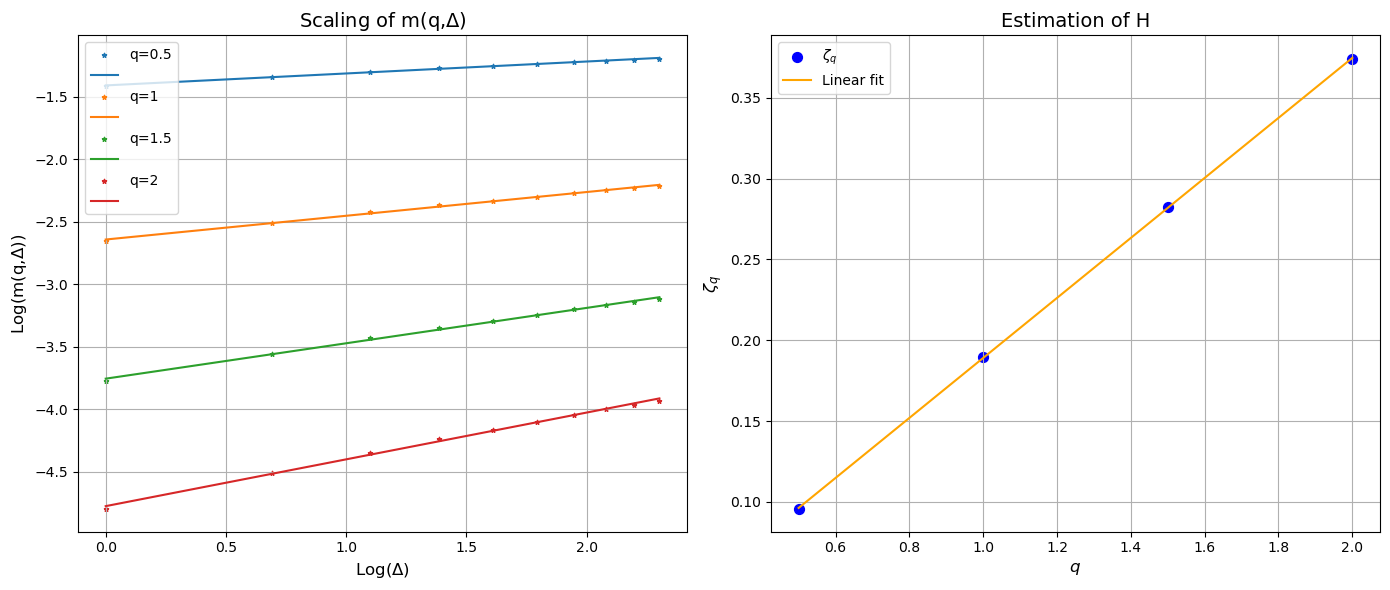

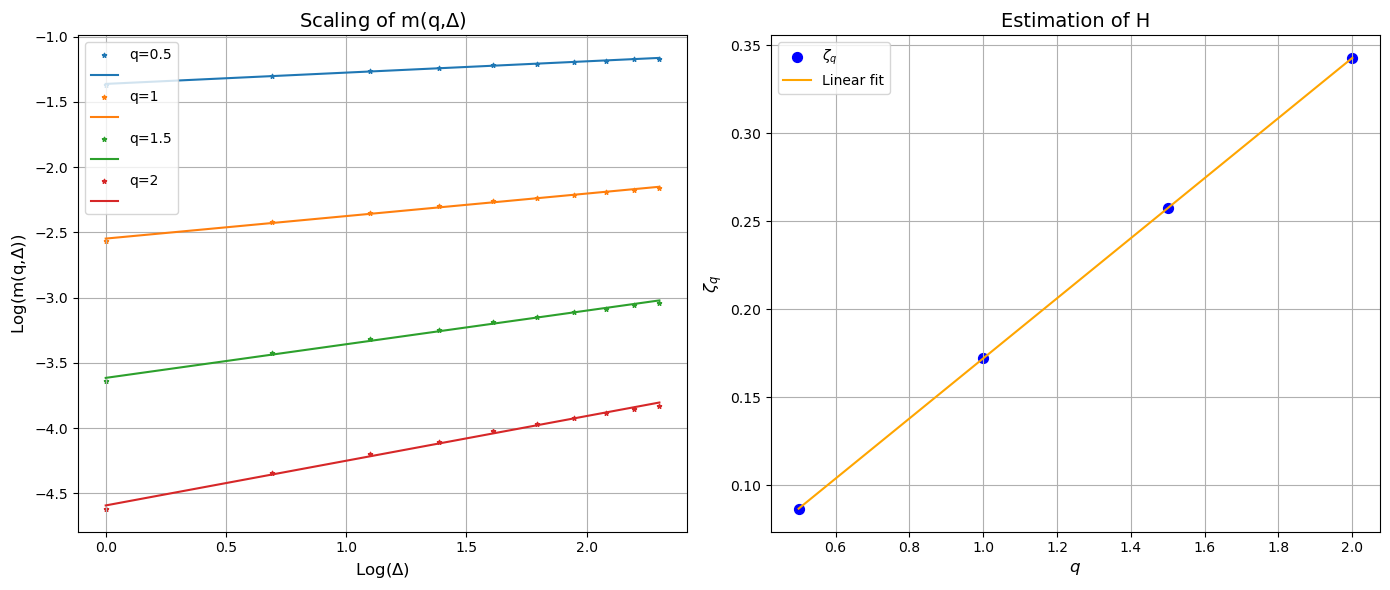

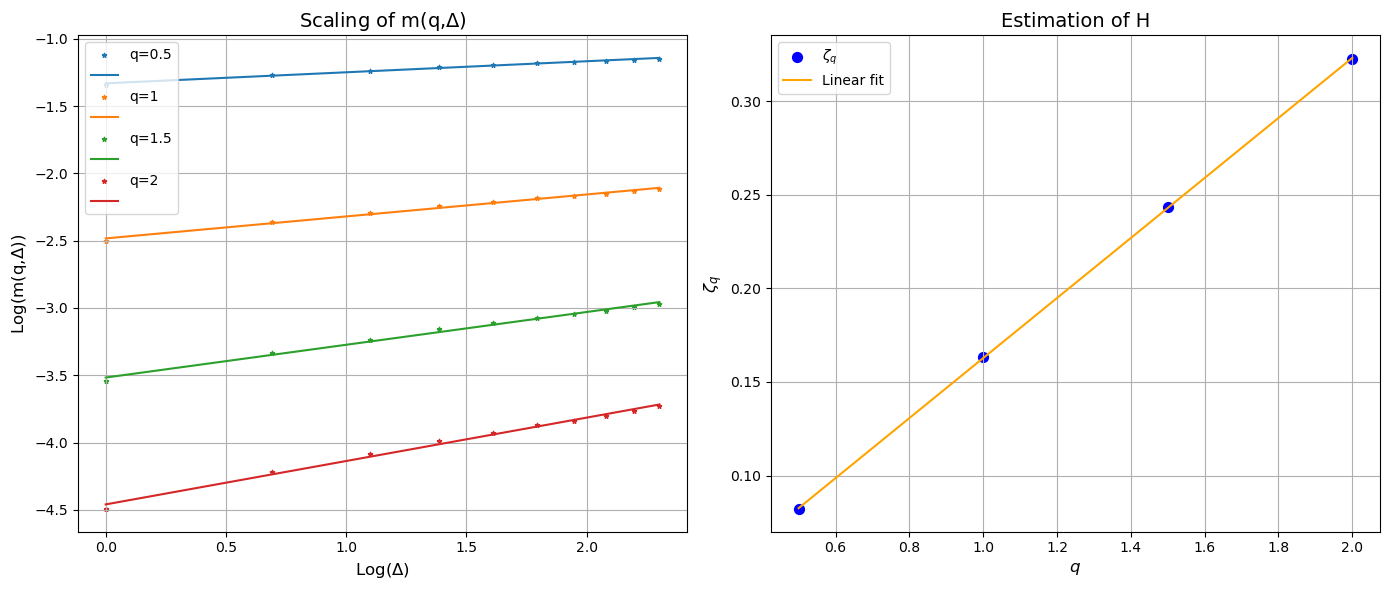

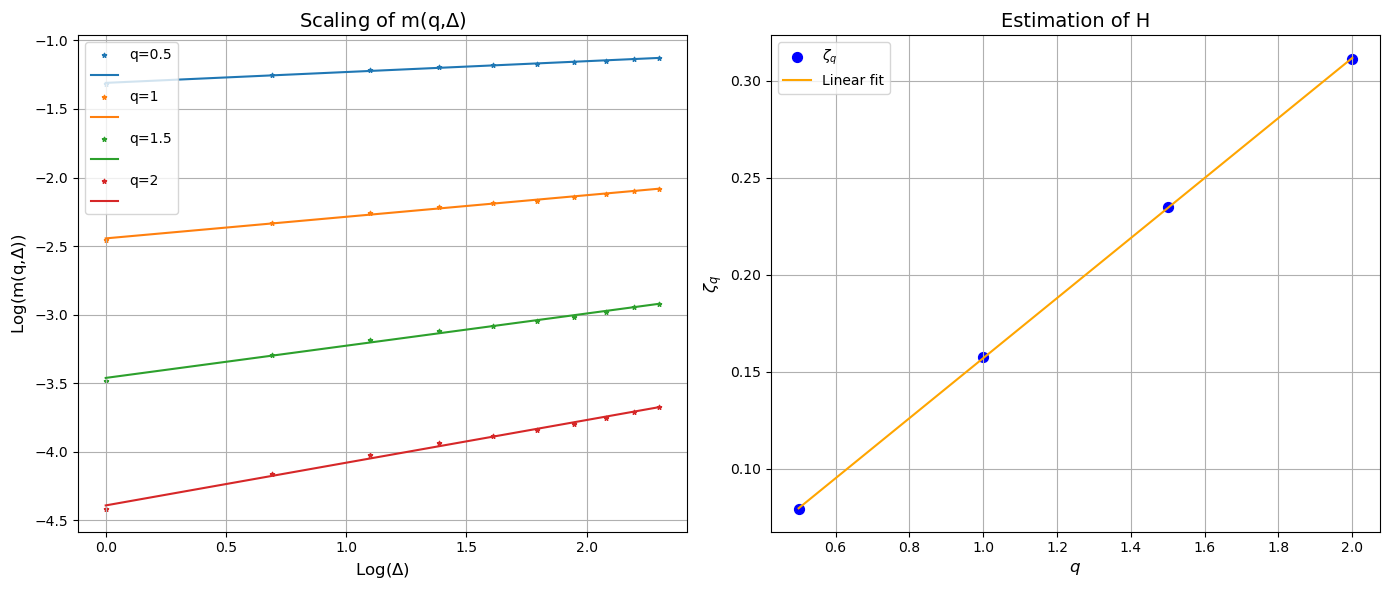

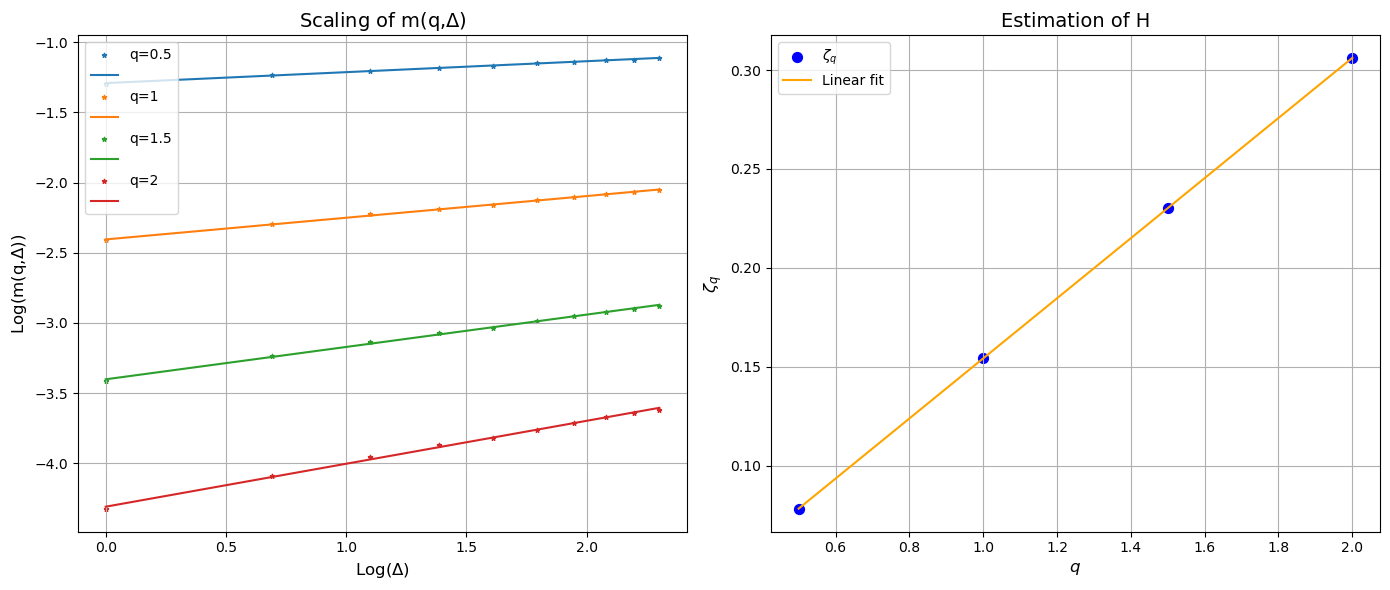

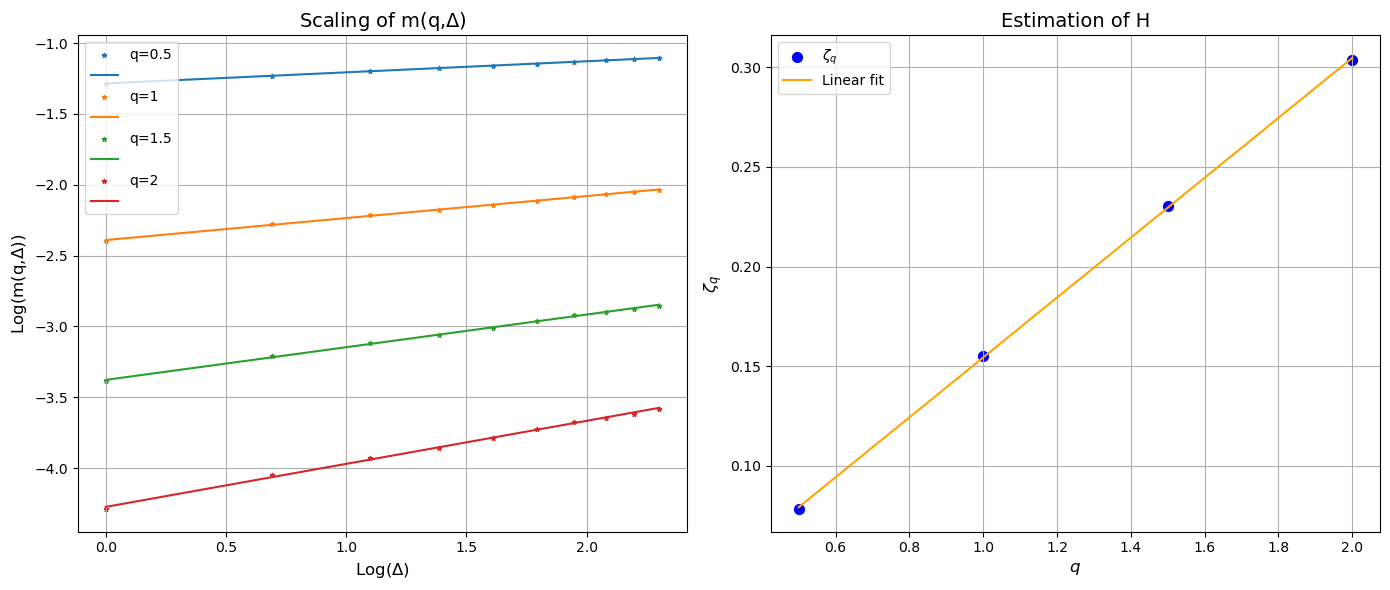

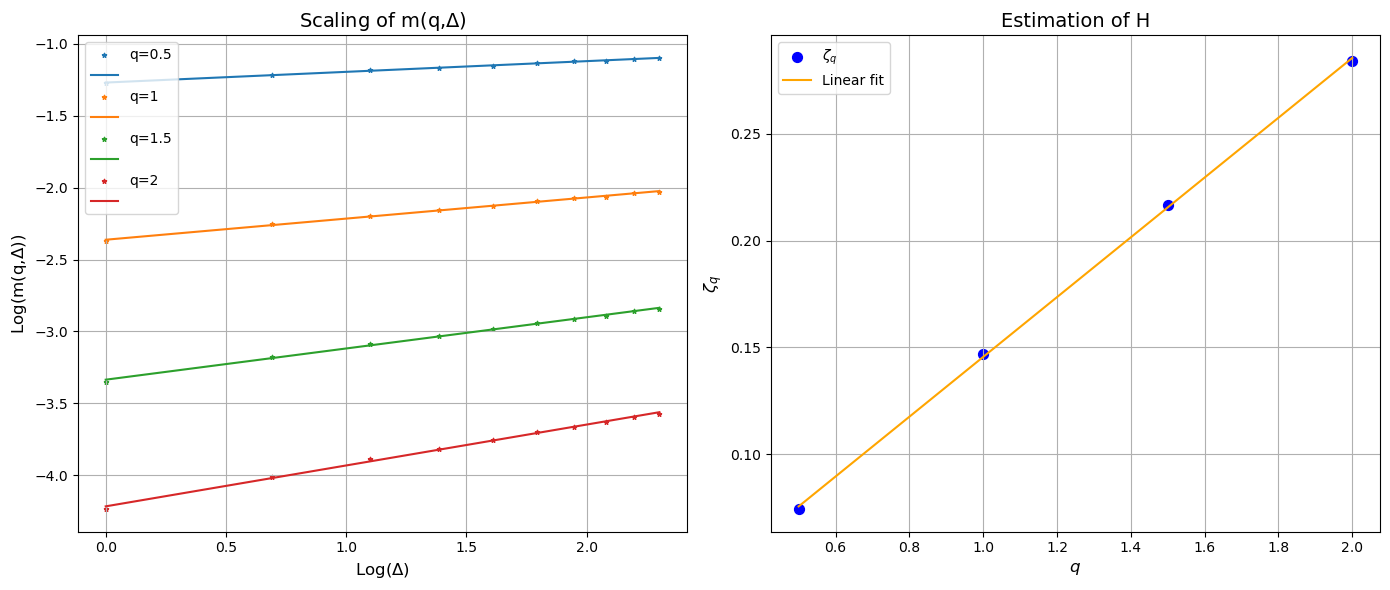

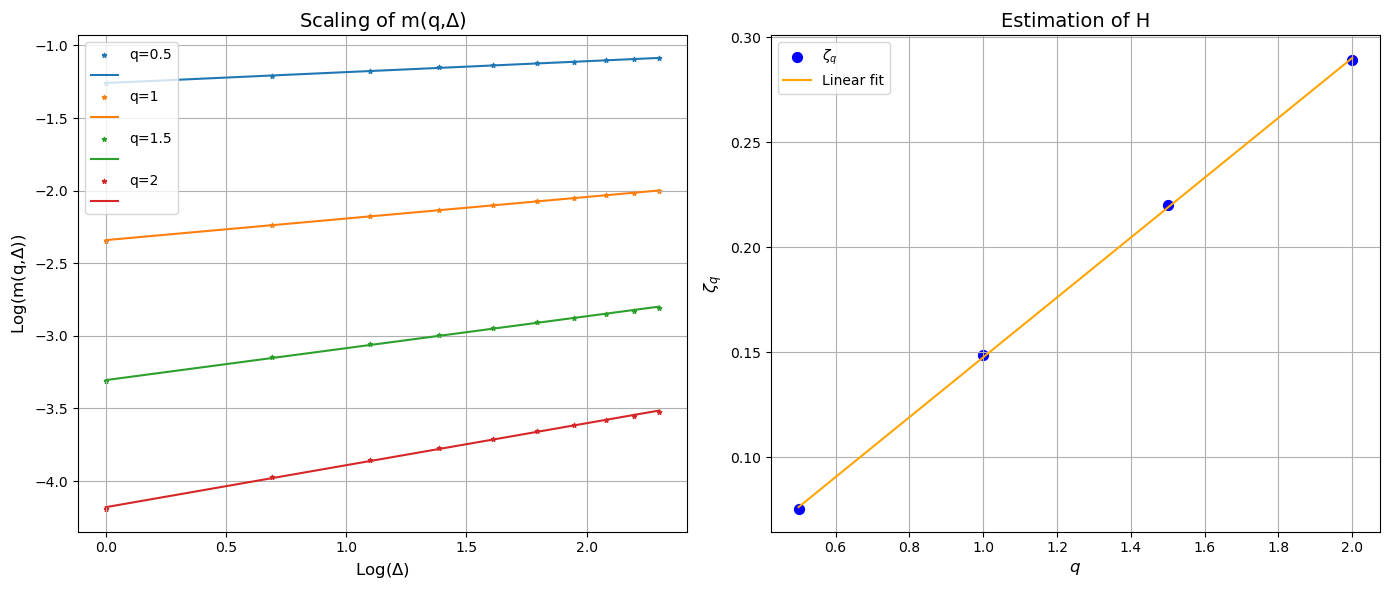

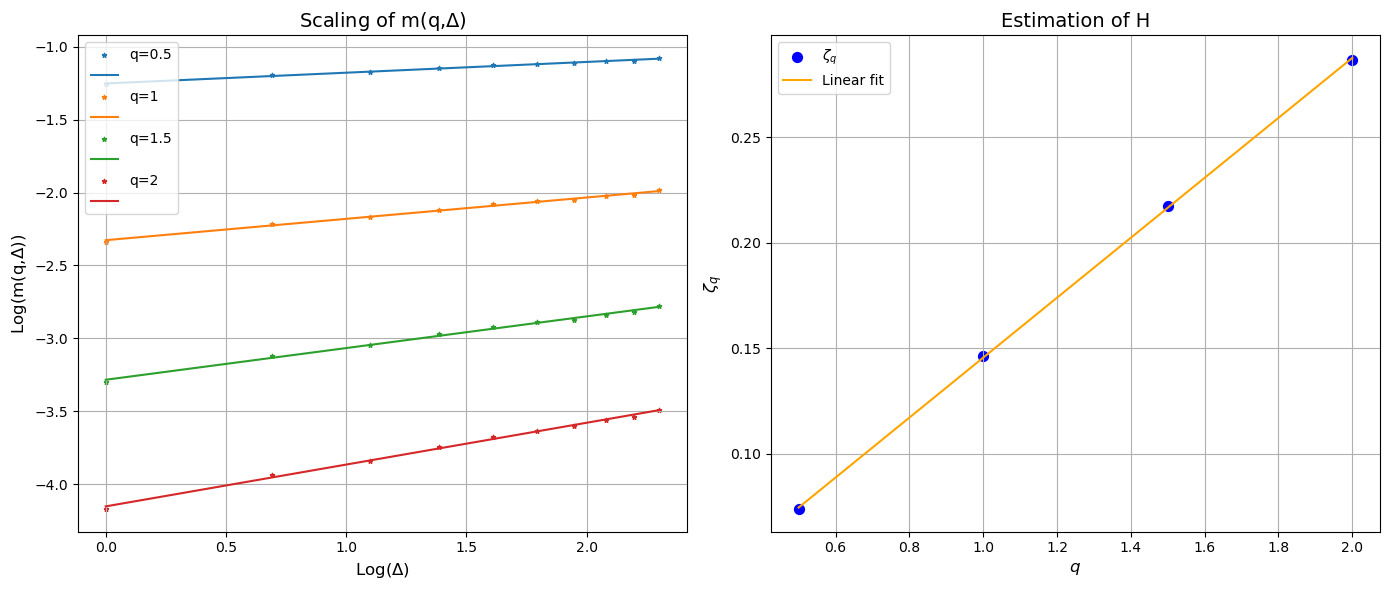

In [26]:
for l in l_values:
    V_l = V[::l]
    H_estimated.append(estimate_H(np.sqrt(V_l), q_values, lag_values))

l_values, H_estimated = np.array(l_values), np.array(H_estimated)

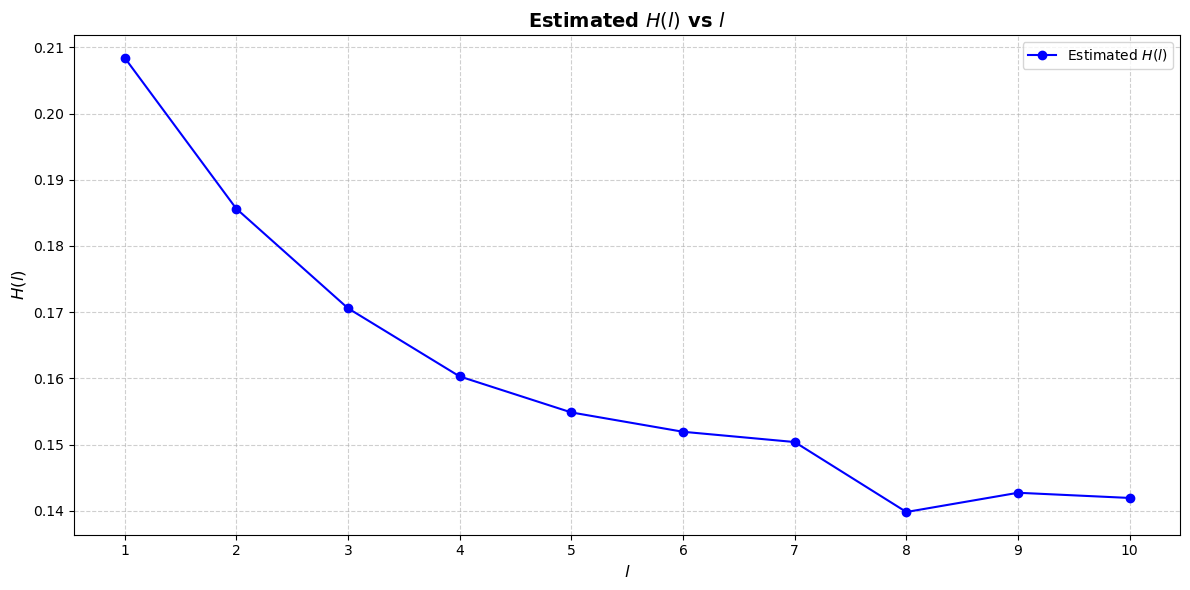

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(l_values, H_estimated, marker='o', linestyle='-', color='b', label=r'Estimated $H(l)$')
plt.xlabel(r'$l$', fontsize=12)
plt.ylabel(r'$H(l)$', fontsize=12)
plt.title(r'Estimated $H(l)$ vs $l$', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(l_values)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Question 4

In [29]:
# Simulation of a brownian motion
G = npr.normal(0, np.sqrt(delta_t), m)
inc = np.cumsum(G)
brownian_motion = np.concatenate(([0], inc))

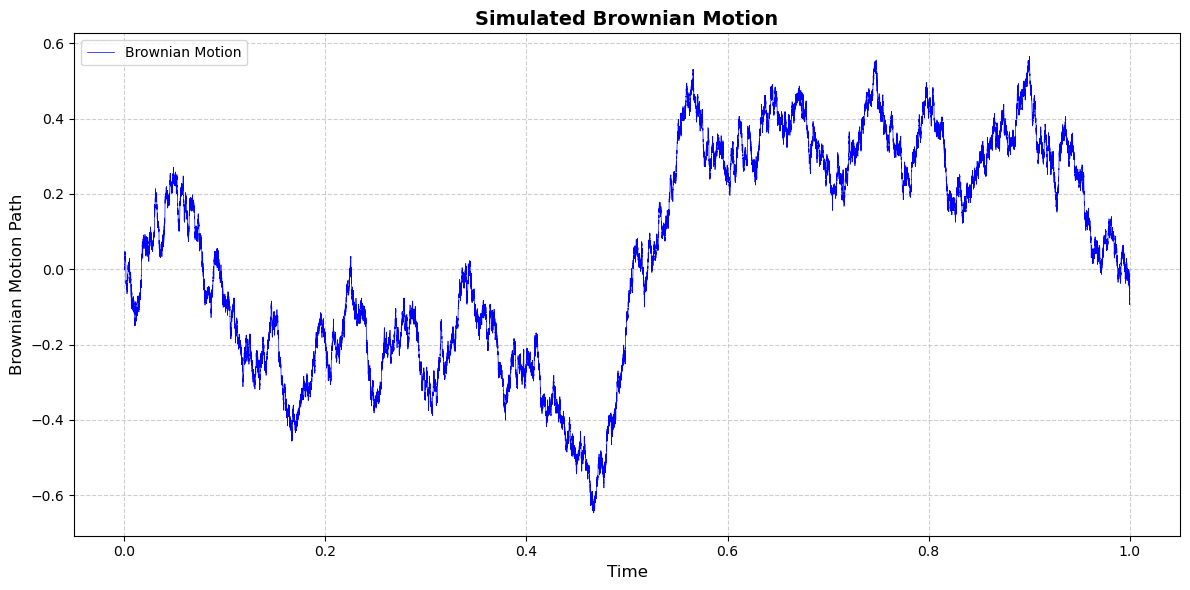

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(time_grid, brownian_motion, color='b', linewidth=0.5, label="Brownian Motion")
plt.title("Simulated Brownian Motion", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Brownian Motion Path", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

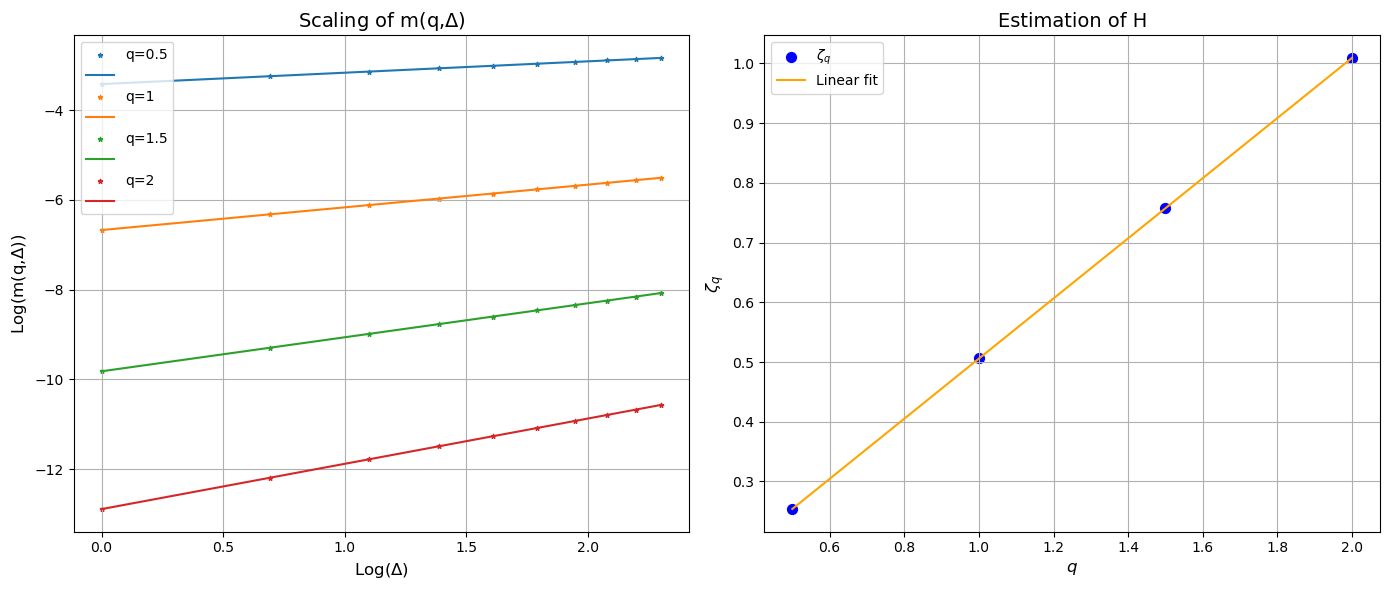

In [31]:
# Estimate H using the exponential of the the brownian motion
H_estimated = estimate_H(np.sqrt(np.exp(brownian_motion)), q_values, lag_values)

In [32]:
H_estimated

0.5036614237534842

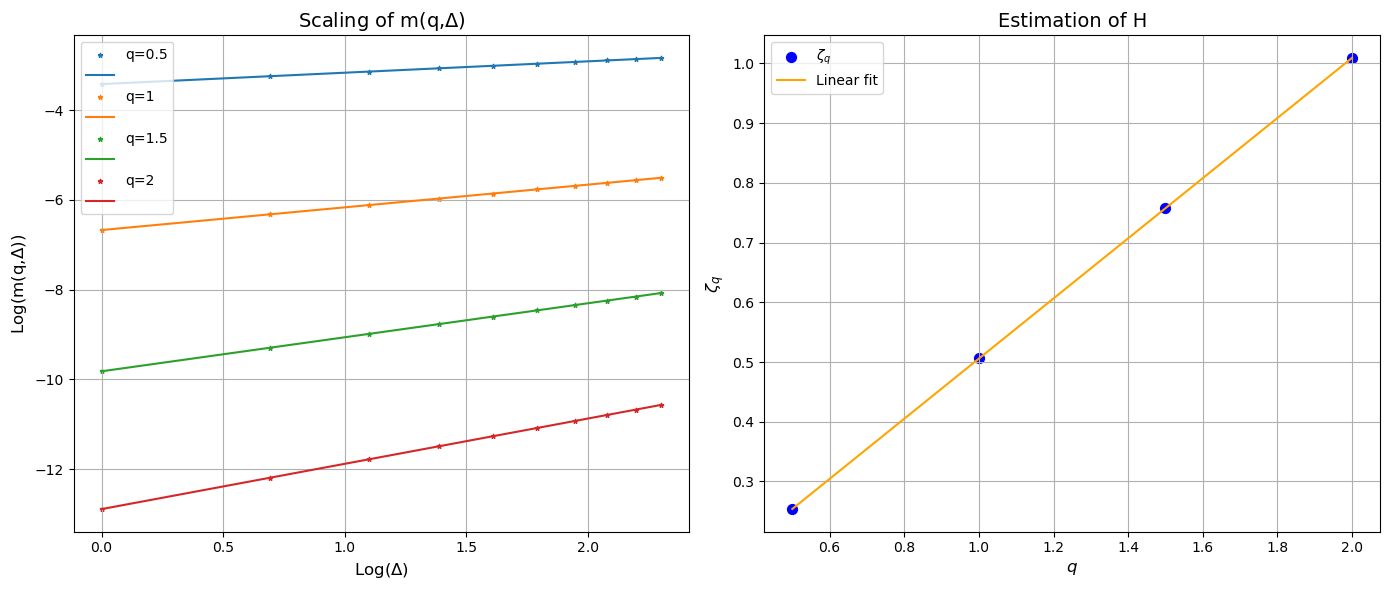

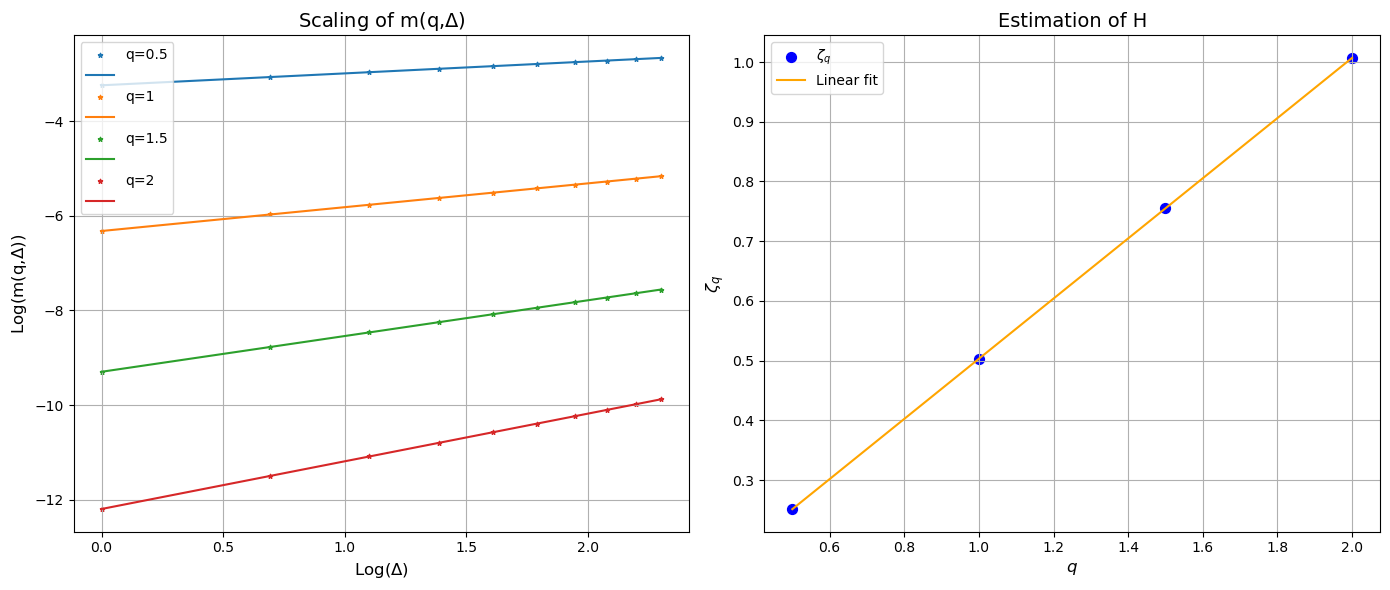

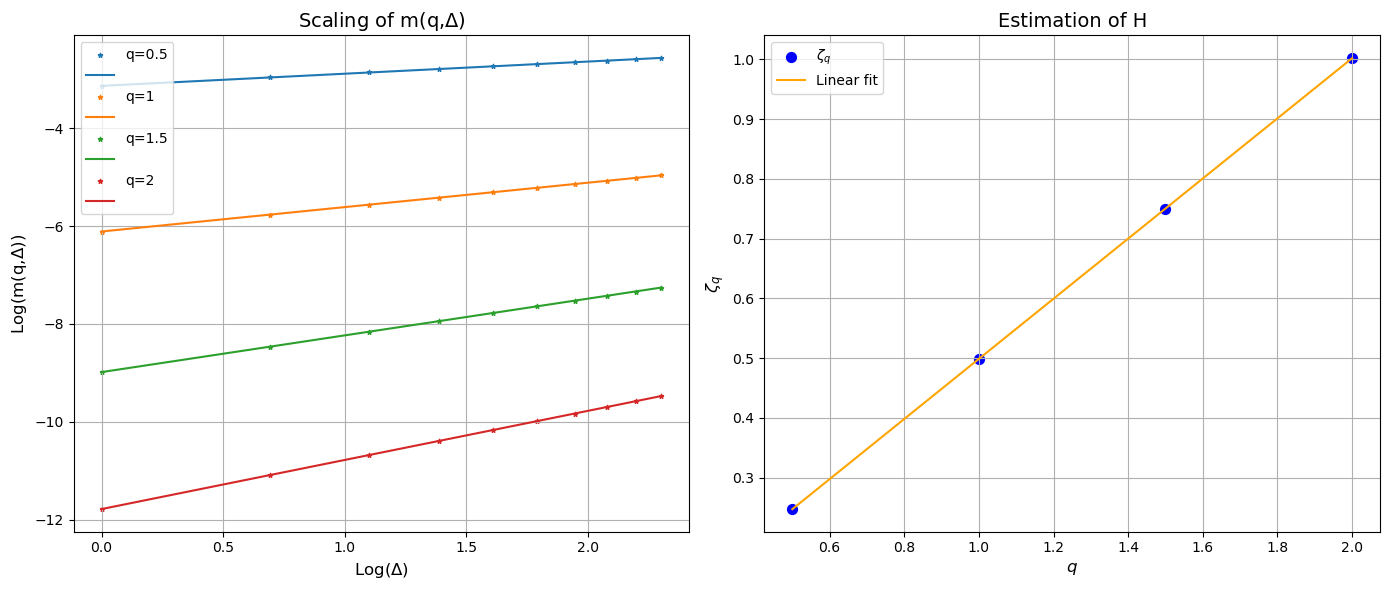

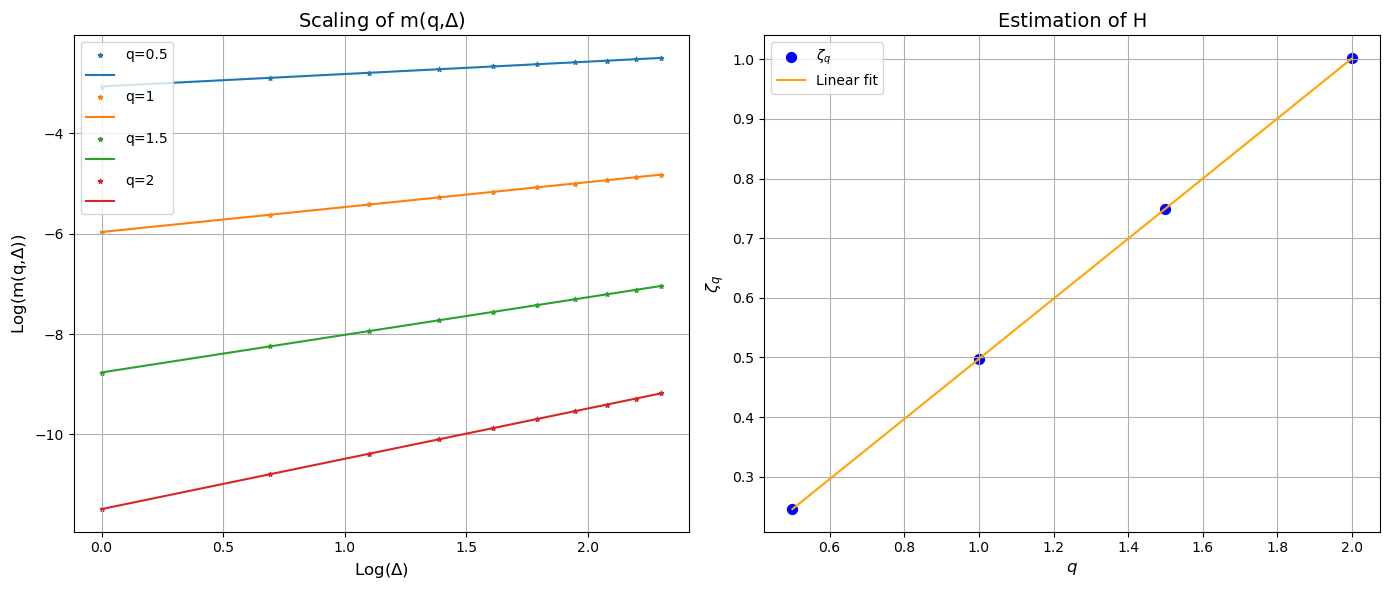

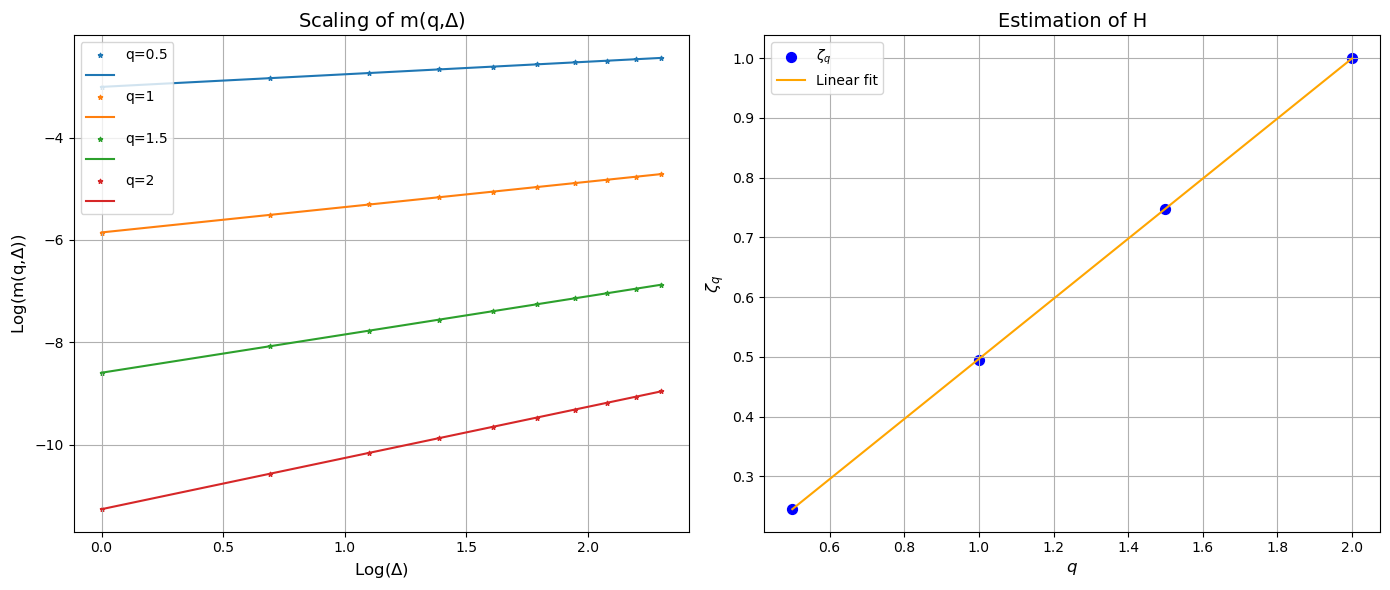

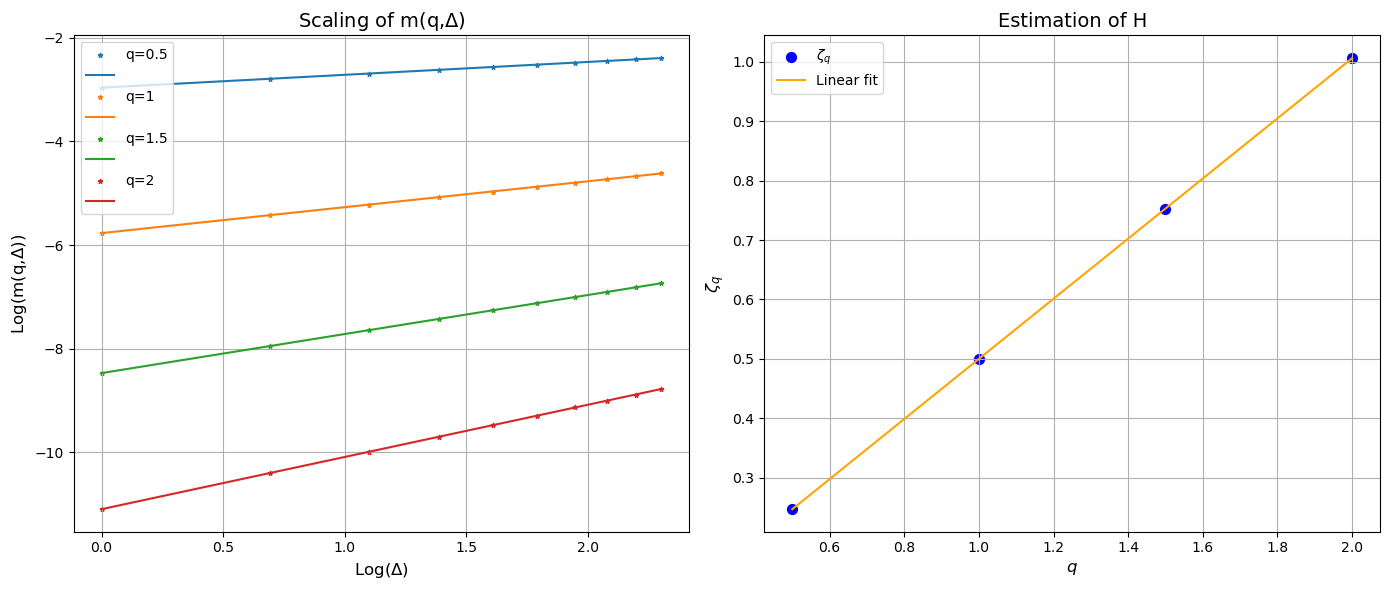

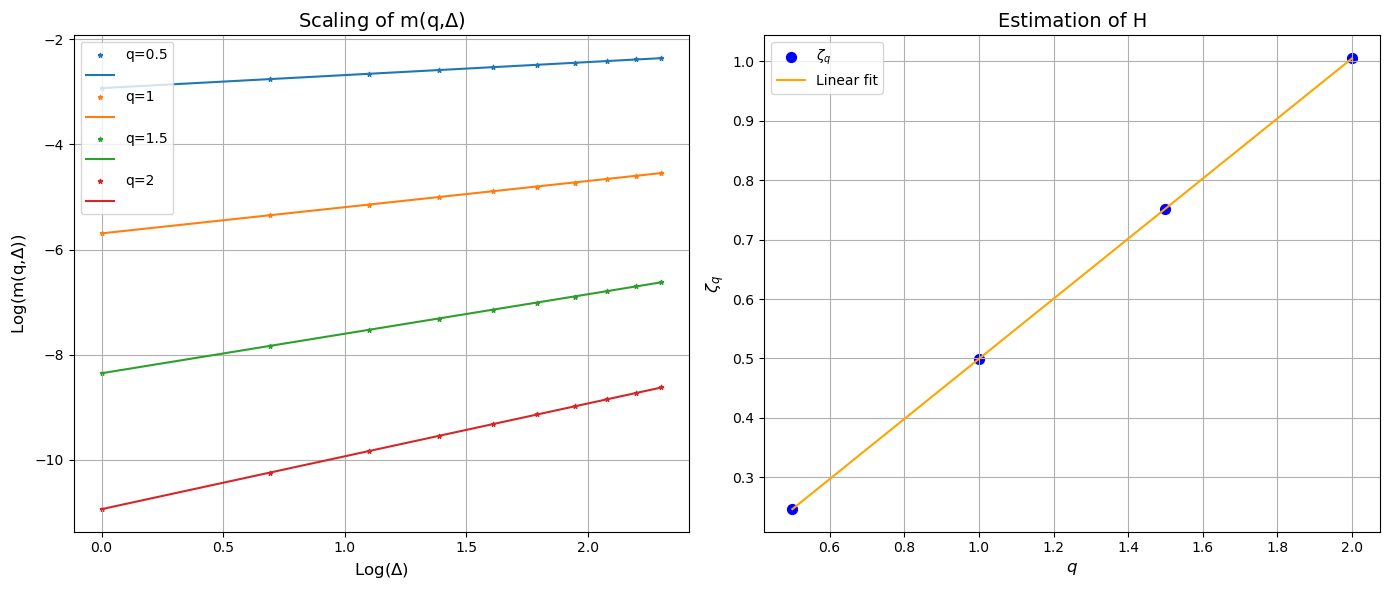

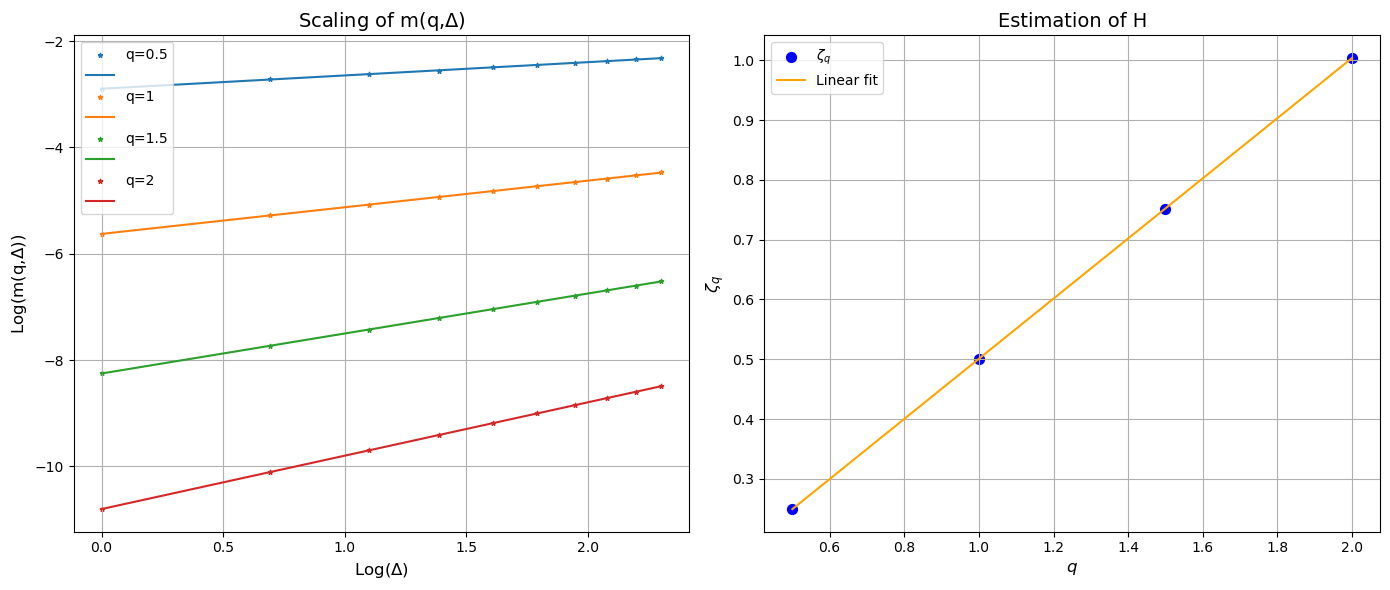

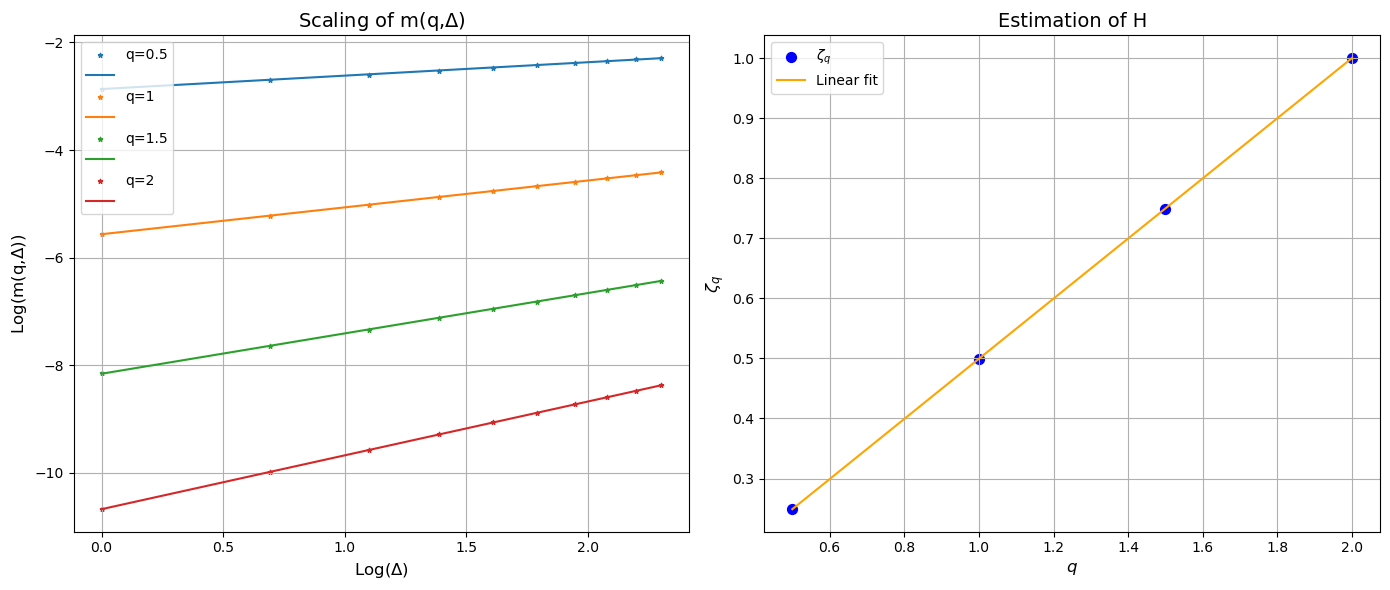

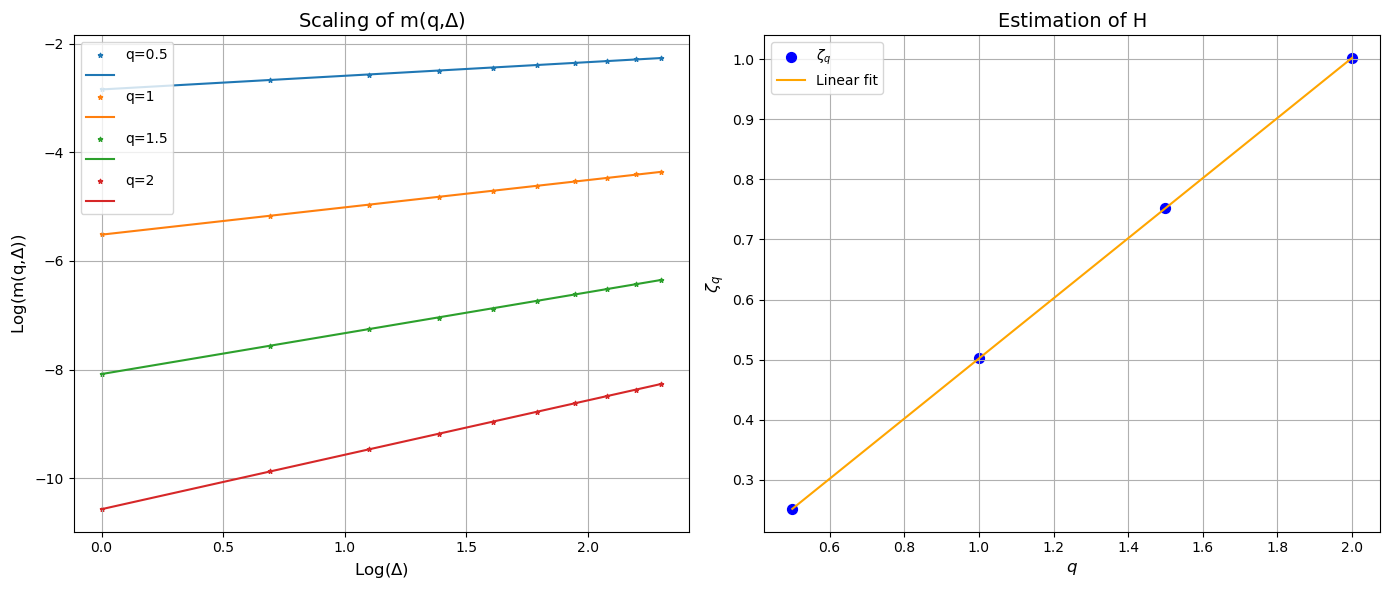

In [33]:
H_estimated = []
for l in l_values:
    W_l = brownian_motion[::l]
    H_estimated.append(estimate_H(np.sqrt(np.exp(W_l)), q_values, lag_values))

l_values, H_estimated = np.array(l_values), np.array(H_estimated)

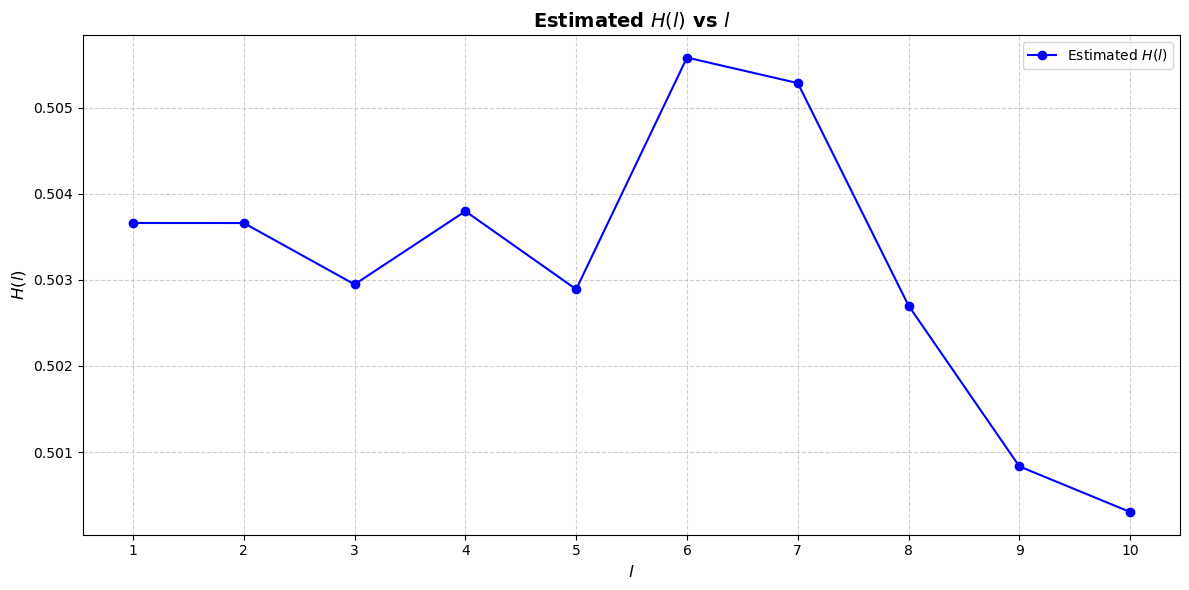

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(l_values, H_estimated, marker='o', linestyle='-', color='b', label=r'Estimated $H(l)$')
plt.xlabel(r'$l$', fontsize=12)
plt.ylabel(r'$H(l)$', fontsize=12)
plt.title(r'Estimated $H(l)$ vs $l$', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(l_values)
plt.legend(fontsize=10)
plt.tight_layout()

## Question 5

In [36]:
# Parameters for the simulation of a fractional brownian motion
m, delta_t, H = 10**3, 1e-3, 0.1
time_grid = np.asarray([delta_t * ii for ii in range(m + 1)])

Fractional Brownian motion (fBm) is a continuous Gaussian process $\{ W_t^H \}_{t \geq 0}$ with:

- **Mean**: $\mathbb{E}[W_t^H] = 0$
- **Covariance function**:

$$
\mathbb{E}[W_t^H W_s^H] = \frac{1}{2} \left( |t|^{2H} + |s|^{2H} - |t - s|^{2H} \right)
$$

where:

- $H \in (0, 1)$ is the **Hurst parameter**

In [38]:
# Simulation of a fractional brownian motion
Sigma = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        # Construction of the covariance matrix
        t, s = time_grid[i + 1], time_grid[j + 1]
        Sigma[i, j] = 0.5 * (np.abs(t)**(2*H) + np.abs(s)**(2*H) - np.abs(t - s)**(2*H))

C, Z = np.linalg.cholesky(Sigma), npr.normal(0, 1, m)
Y = C @ Z
fractional_brownian_motion = np.concatenate(([0], Y))

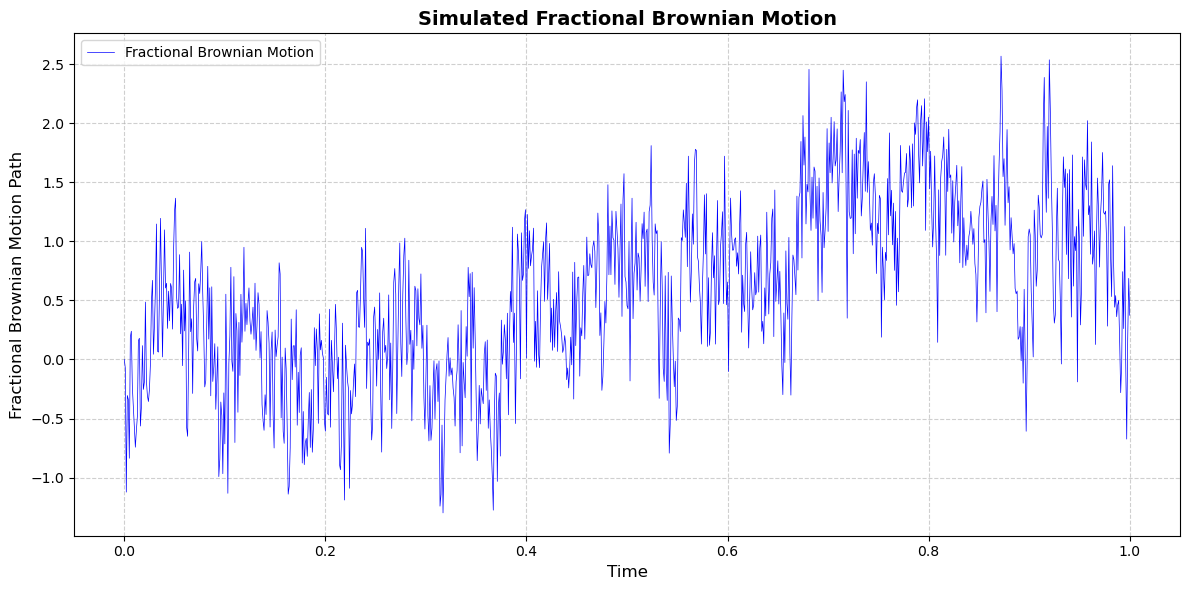

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(time_grid, fractional_brownian_motion, color='b', linewidth=0.5, label="Fractional Brownian Motion")
plt.title("Simulated Fractional Brownian Motion", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Fractional Brownian Motion Path", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

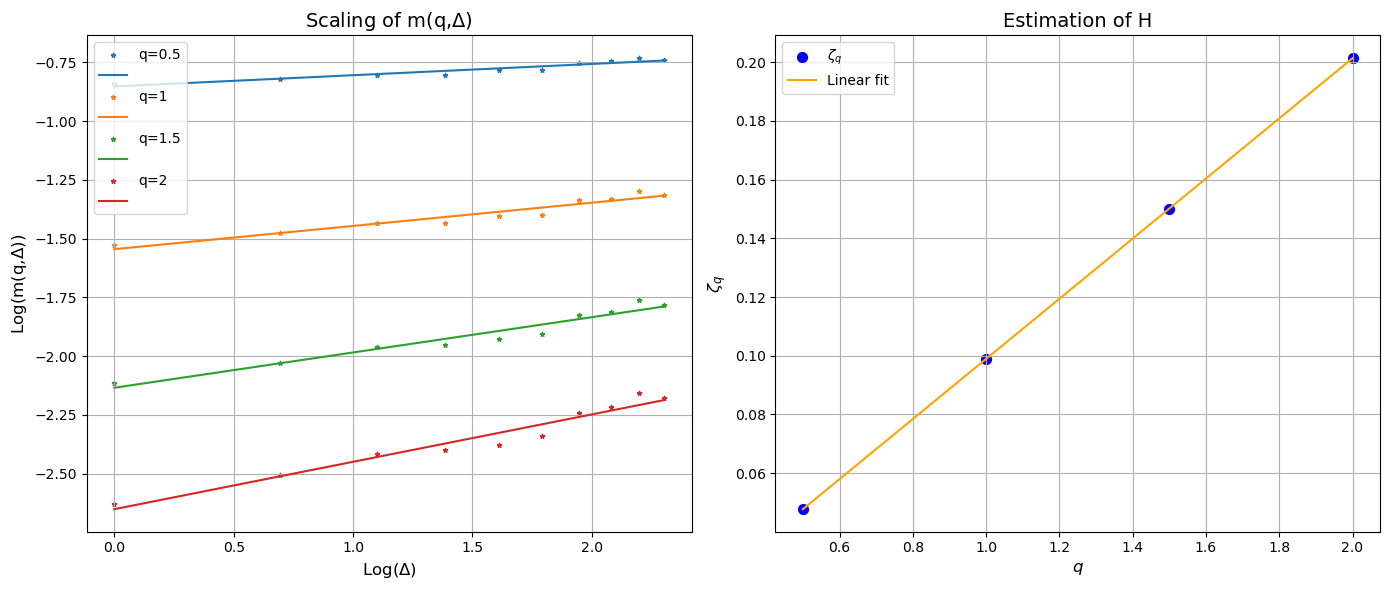

In [40]:
# Estimate H using the exponential of the the fractional brownian motion
H_estimated = estimate_H(np.sqrt(np.exp(fractional_brownian_motion)), q_values, lag_values)

In [41]:
H_estimated

0.10241784062200539

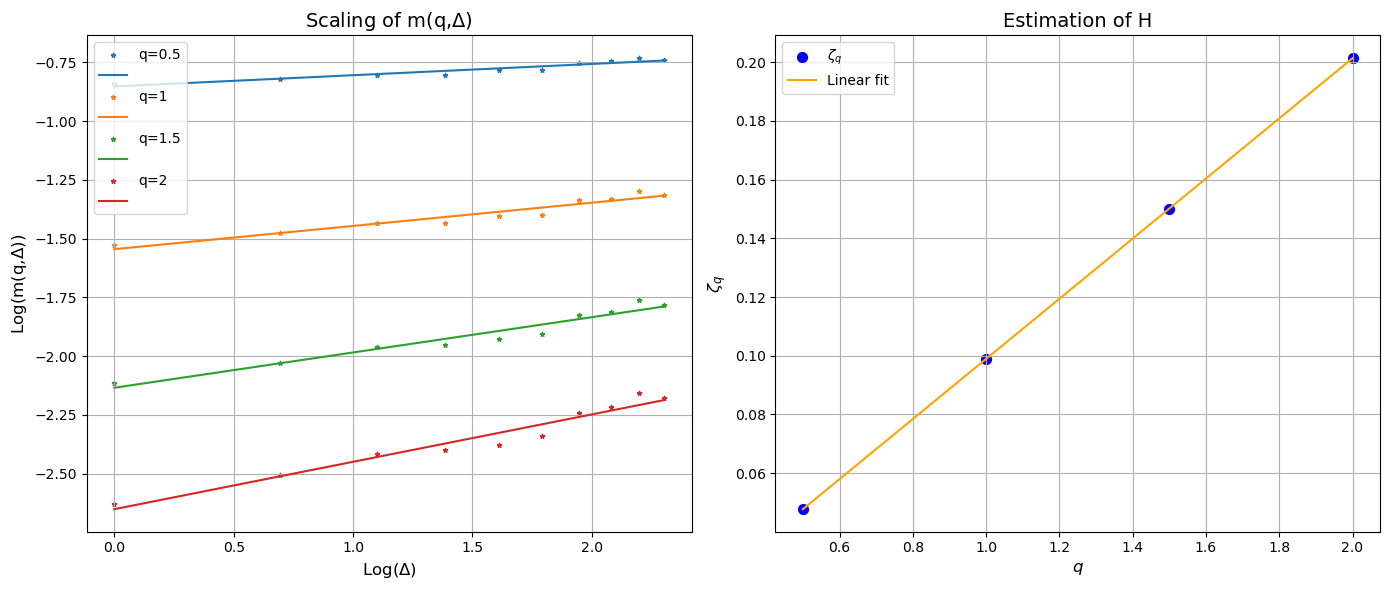

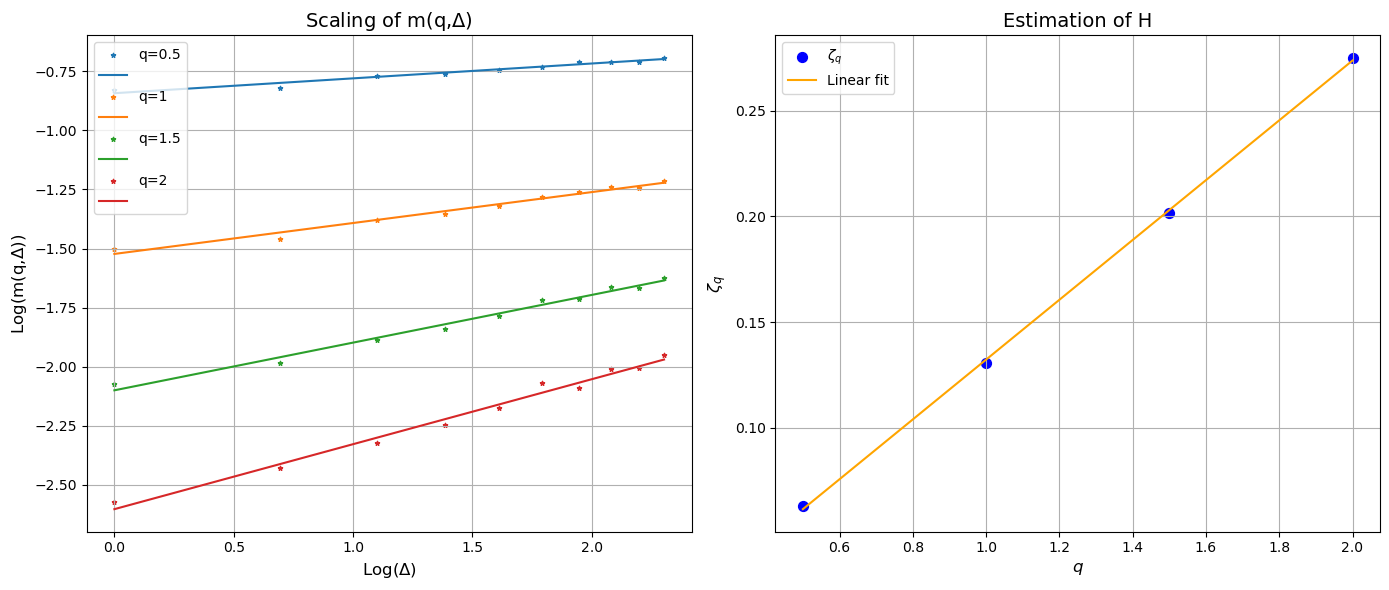

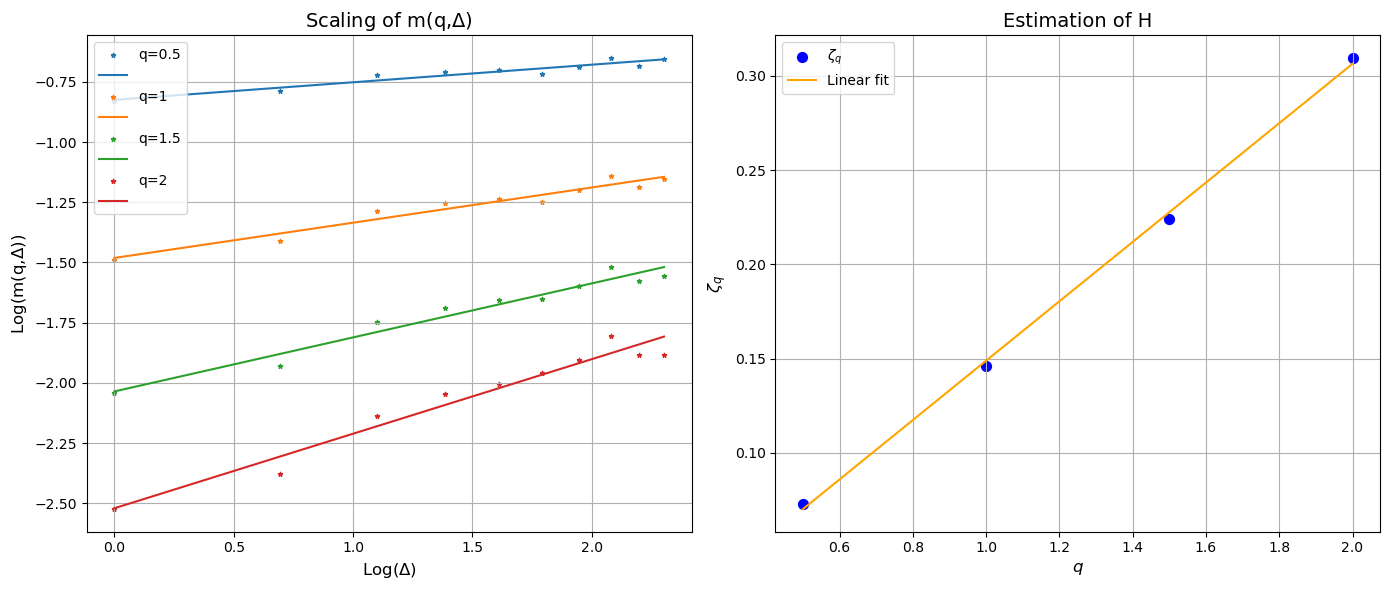

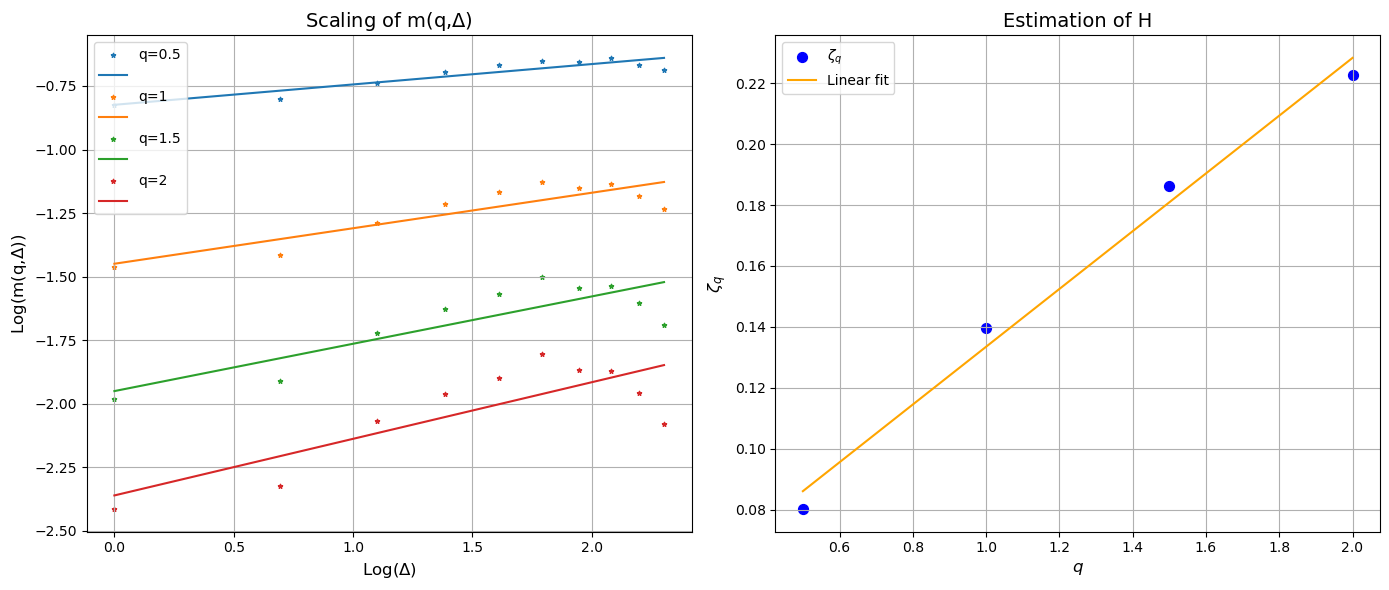

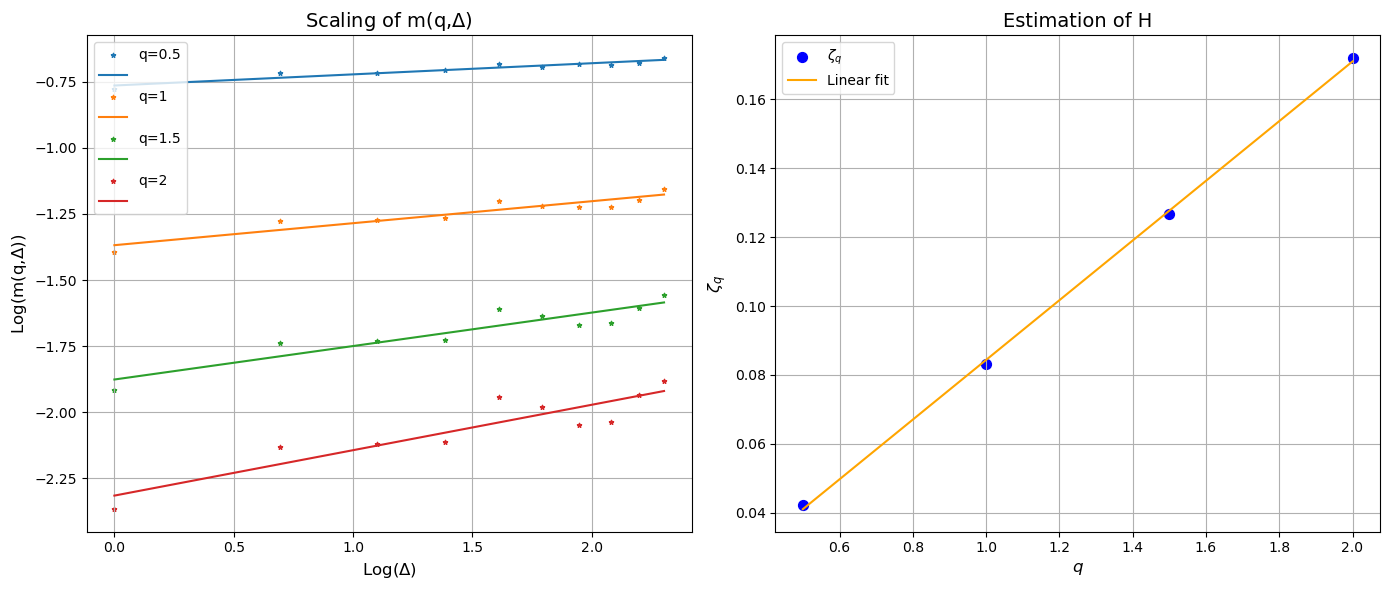

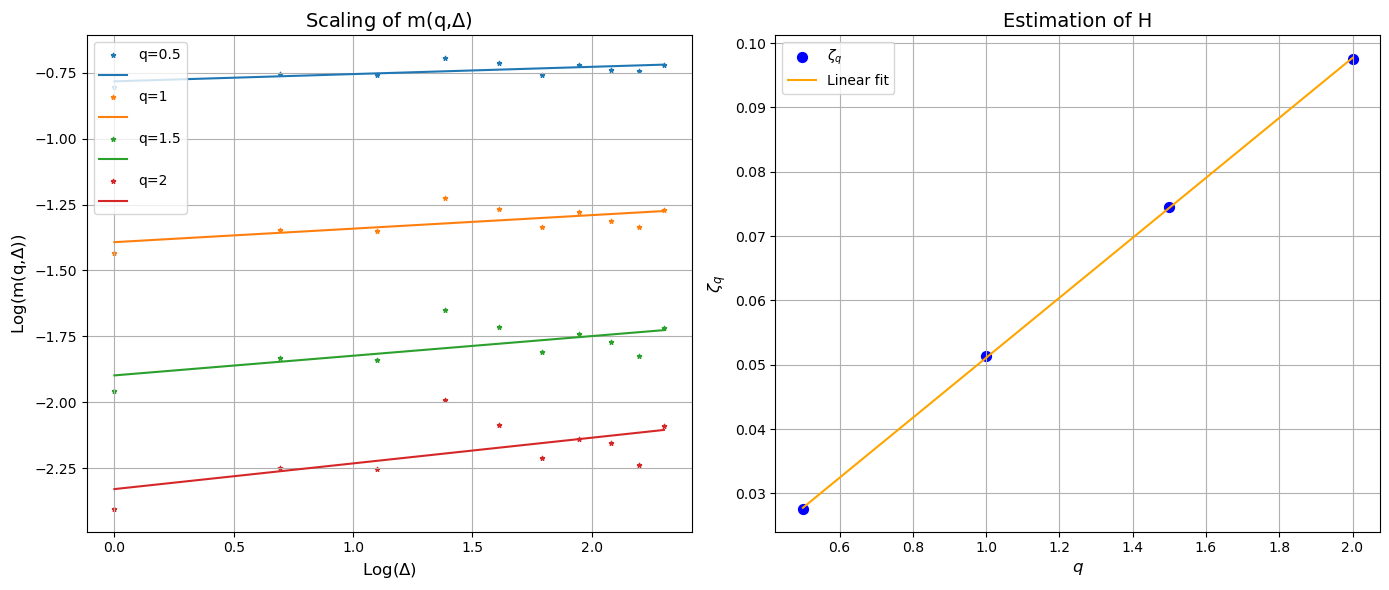

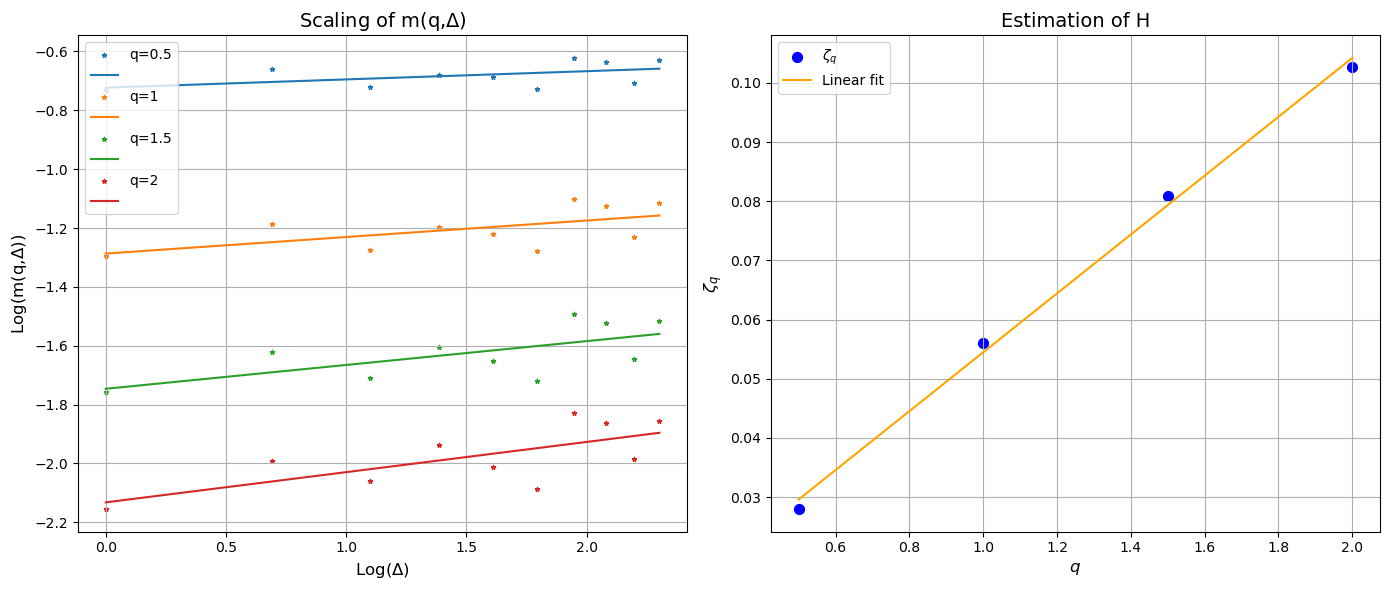

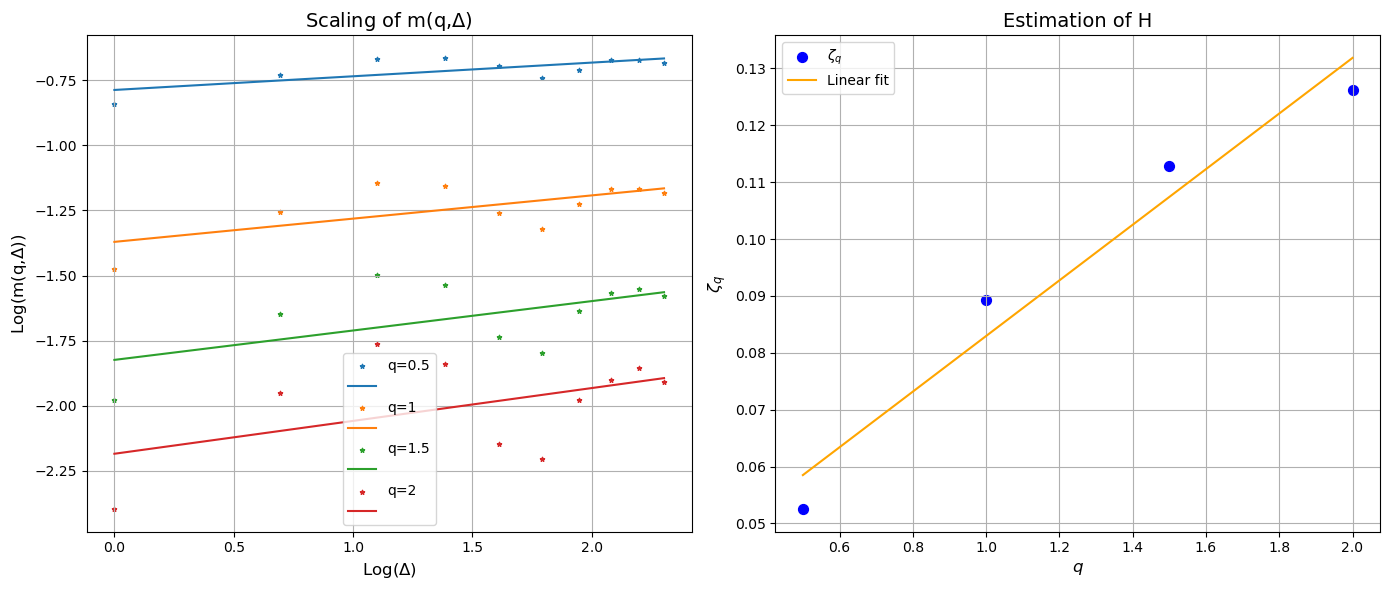

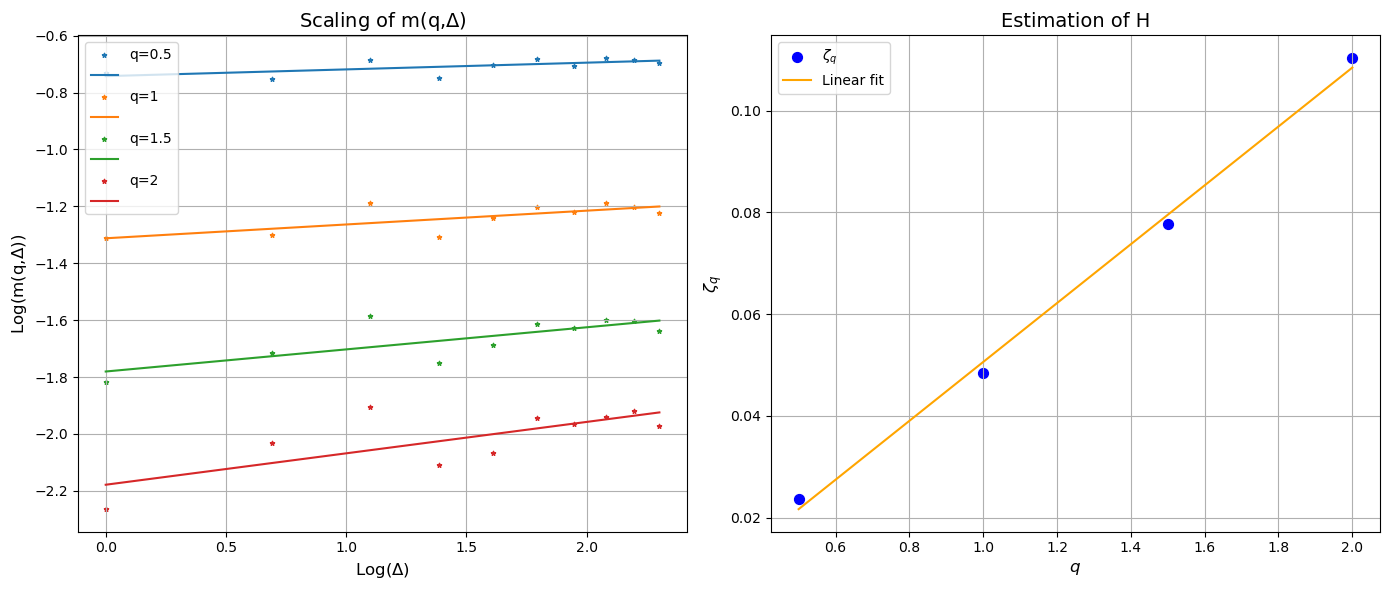

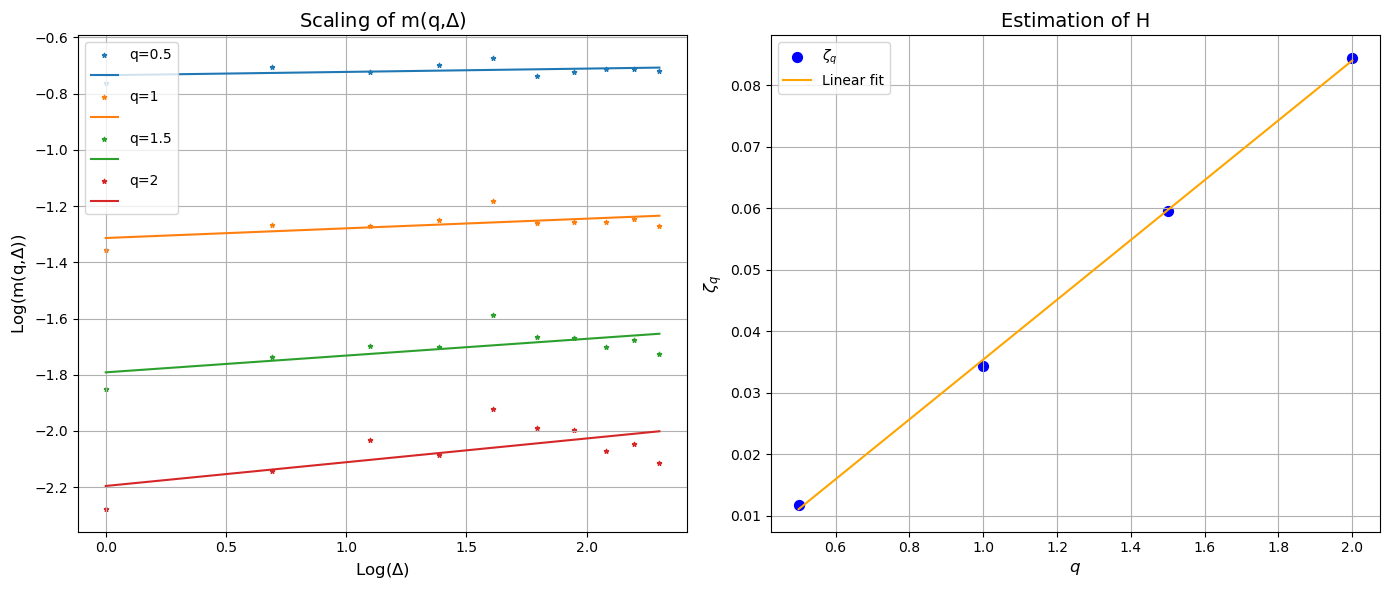

In [42]:
H_estimated = []
for l in l_values:
    W_l = fractional_brownian_motion[::l]
    H_estimated.append(estimate_H(np.sqrt(np.exp(W_l)), q_values, lag_values))

l_values, H_estimated = np.array(l_values), np.array(H_estimated)

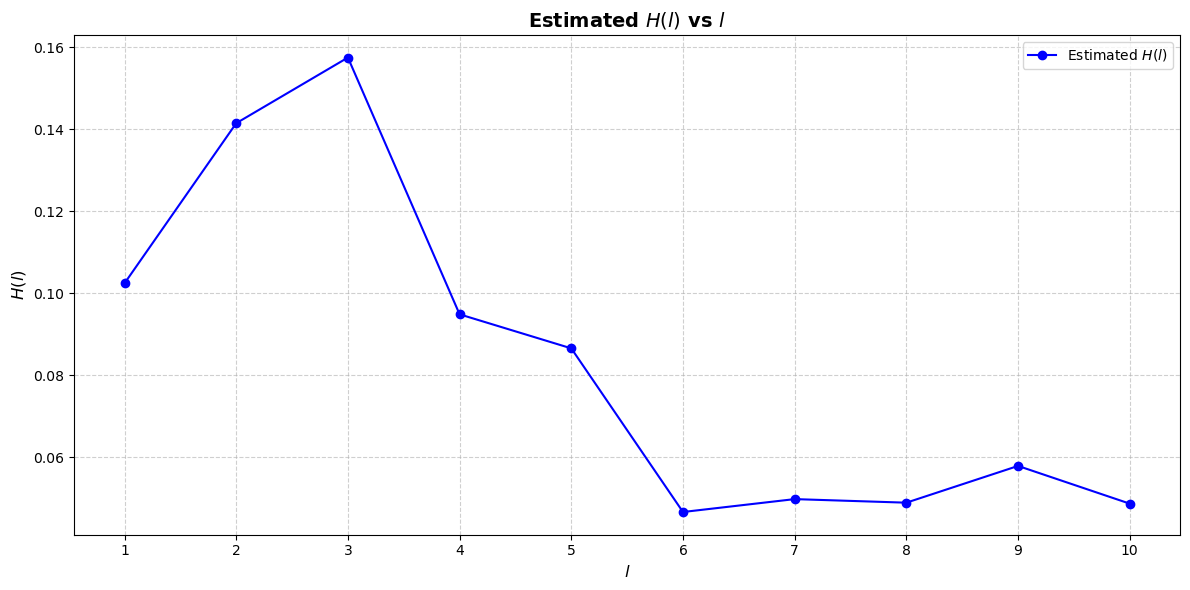

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(l_values, H_estimated, marker='o', linestyle='-', color='b', label=r'Estimated $H(l)$')
plt.xlabel(r'$l$', fontsize=12)
plt.ylabel(r'$H(l)$', fontsize=12)
plt.title(r'Estimated $H(l)$ vs $l$', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(l_values)
plt.legend(fontsize=10)
plt.tight_layout()